# **Etape 0 : Web Scrapping et Consolidation des données**

In [ ]:
import numpy as np
import pandas as pd
import re
import time
# Selenium
import warnings
warnings.filterwarnings("ignore")
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
driver = webdriver.Chrome(executable_path='./chromedriver.exe') # ça marche en local

driver.maximize_window()

df_jeuxvideo = pd.read_csv("vgsales.csv")

Recherche sur Metacritic

In [ ]:
# Ajout d'une colonne pour renommer les plateformes
df_jeuxvideo["Platform_rename"] = df_jeuxvideo.Platform.replace({'2600': 'Atari 2600',
'3DO': '3DO',
'3DS': '3DS',
'DC': 'Dreamcast',
'DS': 'DS',
'GB': 'Game Boy',
'GBA': 'Game Boy Advance',
'GC': 'GameCube',
'GEN': 'Genesis',
'GG': 'Game Gear',
'N64': 'Nintendo 64',
'NES': 'NES',
'NG': 'Neo-Geo',
'PC': 'PC',
'PCFX': 'PC-FX',
'PS': 'PlayStation',
'PS2': 'PlayStation 2',
'PS3': 'PlayStation 3',
'PS4': 'PlayStation 4',
'PSP': 'PSP',
'PSV': 'PlayStation Vita',
'SAT': 'Saturn',
'SCD': 'Sega CD',
'SNES': 'SNES',
'TG16': 'TurboGrafx-16',
'WS': 'WonderSwan',
'Wii': 'Wii',
'WiiU': 'Wii U',
'X360': 'Xbox 360',
'XB': 'Xbox',
'XOne': 'Xbox One'})

In [ ]:
# Ouverture du site metacritic
url = 'https://www.metacritic.com/'
driver.get(url)

time.sleep(5)
# Fermeture de la page des cookies
webelement = driver.find_element(by = 'id', value = "onetrust-reject-all-handler")
driver.execute_script("arguments[0].click();", webelement);

In [ ]:
# Fonctions utilisées pour chercher sur le site de Metacritic
def recherche_Metacritic(jeu_video, plateforme):
    '''
        Recherche du jeu via la barre de recherche
        et affichage de sa page des détails
    '''
    # Saisie dans la barre de recherche et affichage du résultat
    barre_recherche = driver.find_element(by = 'name', value = "search_term")
    barre_recherche.clear()
    barre_recherche.send_keys(jeu_video)
    time.sleep(1)
    barre_recherche.send_keys(Keys.ENTER)
    # Attente
    time.sleep(5)
    # Si la plateforme est la Vita
    if plateforme == 'PSV':
        plateforme = 'VITA'
    elif plateforme == 'XB':
        plateforme = 'XBOX'
    # Récupération du bon jeu dans les résultats
    list_plateformes = driver.find_elements_by_xpath('//span[@class = "platform"]')
    #list_liens = driver.find_elements(by = 'link text', value = jeu_video)
    list_liens = driver.find_elements_by_xpath('//h3[@class = "product_title basic_stat"]//a')

    for p, l in zip(list_plateformes, list_liens):
        if (p.text == plateforme) & (l.text.lower() == jeu_video.lower()):
            l.click()
            break
    # Attente
    time.sleep(5)
    # Aller sur la page des détails. Si la page n'a pas été trouvée, c'est ce qui fera planter la fonction
    moreDetails = driver.find_element(by = 'partial link text', value = 'More Details and Credits')
    moreDetails.click()

def recherche_via_Google(jeu_video, plateforme):
    '''
        Recherche avec la barre de recherche et ouverture du premier lien metacritic
    '''
    # Ouverture de la page Google
    driver.get('https://www.google.com/')
    # Fermeture de la page des cookies
    try:
        webelement = driver.find_element(by = 'id', value = "W0wltc")
        driver.execute_script("arguments[0].click();", webelement);
    except:
        pass
    time.sleep(1)
    # Recherche avec la barre de recherche
    barre_recherche = driver.find_element(by = 'name', value = "q")
    barre_recherche.send_keys(jeu_video + " " + plateforme + " metacritic ")
    time.sleep(1)
    barre_recherche.send_keys(Keys.ENTER)
    time.sleep(2)
    # Ouverture du premier lien metacritic, plantage sinon
    metacritic = driver.find_elements(by = 'partial link text', value = "metacritic")
    for lien in metacritic:
        if "www.metacritic.com" in lien.text:
            lien.click()
            break
    # Attente
    time.sleep(5)

#Fonctions de récupération des informations
def get_Note_Pro():
    '''
        Récupération de la note des professionnels si elle existe
    '''
    notepro = driver.find_element_by_xpath('//span[@itemprop = "ratingValue"]')
    time.sleep(1)
    return notepro.text
def get_Note_Joueurs():
    '''
        Récupération de la note moyenne des joueurs si elle existe
    '''
    notejoueurs = driver.find_element_by_xpath('//div[@class = "metascore_w user large game positive"]')
    if notejoueurs.text == "":
        notejoueurs = driver.find_element_by_xpath('//div[@class = "metascore_w user large game mixed"]')
    if notejoueurs.text == "":
        notejoueurs = driver.find_element_by_xpath('//div[@class = "metascore_w user large game negative"]')
    time.sleep(1)

    return notejoueurs.text

def get_Description():
    '''
        Récupération de la description du jeu si elle existe
    '''
    description = driver.find_element_by_xpath('//div[@class = "summary_detail product_summary"]//span[@class = "data"]')
    time.sleep(1)
    return description.text.replace(",", " ")

def get_Developpeur(blocdetails):
    '''
        Récupération du développeur du jeu s'il existe
    '''
    developpeur = re.findall("Developer: ([a-zA-Z0-9_.\ -]+)", blocdetails.text)[0]
    time.sleep(1)
    return developpeur

def get_Rating(blocdetails):
    '''
        Récupération du développeur du "rating" s'il existe
    '''
    rating = re.findall("Rating: ([a-zA-Z0-9_+]+)", blocdetails.text)[0]
    time.sleep(1)
    return rating

def get_Nb_Joueurs(blocdetails):
    '''
        Récupération du "Nombre de joueurs" s'il existe
        Permet de savoir si le jeu peut être joué à plusieurs ou non en local
    '''
    nb_joueurs = re.findall("Number of Players: ([a-zA-Z0-9_.\ -]+)", blocdetails.text)[0]
    time.sleep(1)
    return nb_joueurs

def get_Online(blocdetails):
    '''
        Récupération du "Nombre de joueurs online" s'il existe
        Permet de savoir si le jeu peut être joué en ligne
    '''
    multi = re.findall("Number of Online Players: ([a-zA-Z0-9_.\ -]+)", blocdetails.text)[0]
    time.sleep(1)
    return multi

In [ ]:
# Traitement de récupération des données avec le temps mis => fait en local
start_time = time.time()
# Morceaux par morceaux
df_morceaux = df_jeuxvideo[0:1001]

# Initialisation des listes des données à récupérer
notes_pro = []
notes_joueurs = []
descriptions = []
developpeurs = []
ratings = []
nb_joueurs = []
online = []

# Pour chaque jeu du dataframe
for jeu_video, plateforme, annee, pf_entier in zip(df_morceaux.Name, df_morceaux.Platform, df_morceaux.Year, df_morceaux.Platform_rename):
    # Accès à la page du jeu
    try:
        recherche_Metacritic(jeu_video, plateforme.upper())
    except:
        try:
            recherche_via_Google(jeu_video, plateforme)
        except:
            notes_pro.append(np.nan)
            notes_joueurs.append(np.nan)
            descriptions.append(np.nan)
            developpeurs.append(np.nan)
            ratings.append(np.nan)
            nb_joueurs.append(np.nan)
            online.append(np.nan)
            # Attente avant de relancer une recherche et on zappe le reste des instructions
            time.sleep(7)
            driver.get(url)
            time.sleep(3)
            continue

        try:
            pf_meta = driver.find_element_by_xpath('//span[@class = "platform"]')
            annee_meta = driver.find_element_by_xpath('//li[@class = "summary_detail release_data"]//span[@class = "data"]')
        except:
            notes_pro.append(np.nan)
            notes_joueurs.append(np.nan)
            descriptions.append(np.nan)
            developpeurs.append(np.nan)
            ratings.append(np.nan)
            nb_joueurs.append(np.nan)
            online.append(np.nan)
            # Attente avant de relancer une recherche et on zappe le reste des instructions
            time.sleep(7)
            driver.get(url)
            time.sleep(3)
            continue
        #Si le champ Year n'est pas alimenté, je ne peux pas vérifier
        if (pd.isna(annee) == False) & (annee_meta.text[0:3] != 'TBA') & (annee_meta.text != 'Unknown') & (annee_meta.text != 'Canceled')  & (annee_meta.text != 'Cancelled'):
            # Si la page semble ok, aller sur la page des détails du jeu
            if (pf_entier.lower() == pf_meta.text.lower()) & ((int(annee) == int(annee_meta.text[-4:])) | (int(annee) == int(annee_meta.text[-4:])-1)):
                try:
                    moreDetails = driver.find_element(by = 'partial link text', value = "Details & Credits")
                    moreDetails.click()
                except:
                    pass
            # Si la page n'est pas la bonne, on met tout à null et on passe au jeu suivant
            else:
                notes_pro.append(np.nan)
                notes_joueurs.append(np.nan)
                descriptions.append(np.nan)
                developpeurs.append(np.nan)
                ratings.append(np.nan)
                nb_joueurs.append(np.nan)
                online.append(np.nan)
                # Attente avant de relancer une recherche et on zappe le reste des instructions
                time.sleep(7)
                driver.get(url)
                time.sleep(3)
                continue
        else:
            notes_pro.append(np.nan)
            notes_joueurs.append(np.nan)
            descriptions.append(np.nan)
            developpeurs.append(np.nan)
            ratings.append(np.nan)
            nb_joueurs.append(np.nan)
            online.append(np.nan)
            # Attente avant de relancer une recherche et on zappe le reste des instructions
            time.sleep(7)
            driver.get(url)
            time.sleep(3)
            continue

    # Attente pour que l'affichage soit ok
    time.sleep(3)
    # Récupération de la note pro (sur 100)
    try:
        notes_pro.append(get_Note_Pro())
    except:
        notes_pro.append(np.nan)
    # Récupération de la note moyenne des joueurs (sur 10)
    try:
        notes_joueurs.append(get_Note_Joueurs())
    except:
        notes_joueurs.append(np.nan)
    # Récupération de la description du jeu
    try:
        descriptions.append(get_Description())
    except:
        descriptions.append(np.nan)

    #Récupération du bloc de détails pour la récupération des informations qui vont suivre
    blocdetails = driver.find_element_by_xpath('//div[@class = "product_details"]')
    # Récupération du développeur
    try:
        developpeurs.append(get_Developpeur(blocdetails))
    except:
        developpeurs.append(np.nan)
    # Récupération du "rating"
    try:
        ratings.append(get_Rating(blocdetails))
    except:
        ratings.append(np.nan)
    # Récupération du "nombre de joueurs"
    try:
        nb_joueurs.append(get_Nb_Joueurs(blocdetails))
    except:
        nb_joueurs.append(np.nan)
    # Récupération du "nombre de joueurs en ligne"
    try:
        online.append(get_Online(blocdetails))
    except:
        online.append(np.nan)
    time.sleep(25)

# Insertion des données dans le DataFrame
df_morceaux["NoteP_Meta"] = notes_pro
df_morceaux["NoteJ_Meta"] = notes_joueurs
df_morceaux["Description_M"] = descriptions
df_morceaux["Developpeur_M"] = developpeurs
df_morceaux["Rating"] = ratings
df_morceaux["Nb_Joueurs"] = nb_joueurs
df_morceaux["NBJ_Online"] = online

# Création d'un fichier csv
df_morceaux.to_csv('vgsales_enrichi_metacritic_1.csv', sep =',', index = False)

print(len(notes_pro), "en")
print("--- %s seconds ---" % (time.time() - start_time))

Recherche sur Wikipedia et Jeuxvideo.com via Google

In [ ]:
df = pd.read_csv("vgsales.csv")

driver2 = webdriver.Chrome(executable_path='./chromedriver.exe') ## avec selenium v3
driver2.maximize_window()

In [ ]:
# Ouverture du site google
url = 'https://www.google.com/'
driver2.get(url)

time.sleep(1)

# Fermeture de la page des cookies
webelement = driver2.find_element(by = 'id', value = "W0wltc")
driver2.execute_script("arguments[0].click();", webelement);

In [ ]:
# Les fonctions
def recherche_Google(jeu_video, plateforme, site):
    '''
        Recherche avec la barre de recherche et ouverture des onglets Wikipedia et Jeuxvideo.com
    '''
    # Recherche avec la barre de recherche
    barre_recherche = driver2.find_element(by = 'name', value = "q")
    barre_recherche.clear()
    barre_recherche.send_keys(jeu_video + " " + plateforme + " " + site)
    time.sleep(4)
    barre_recherche.send_keys(Keys.ENTER)
    # Attente
    time.sleep(15)

def get_onglet_Jeuxvideo(jeu_video, plateforme):
    '''
        Recherche d'une page Jeuxvideo.com et ouverture d'un onglet
    '''
    recherche_Google(jeu_video, plateforme, "jeuxvideo.com")
    try:
        jvc = driver2.find_elements(by = 'partial link text', value = "jeuxvideo.com")
    except:
        return "KO"
    # Pour éviter les corrections de Google
    for lien in jvc:
        if "www.jeuxvideo.com" in lien.text:
            webdriver.ActionChains(driver2).key_down(Keys.CONTROL).click(lien).key_up(Keys.CONTROL).perform()
            return "OK"
            break
        else:
            return "KO"

def get_onglet_Wikipedia(jeu_video, plateforme):
    '''
        Recherche d'une page Wikipedia et ouverture d'un onglet
    '''
    recherche_Google(jeu_video, plateforme, "wikipedia")
    try:
        wiki = driver2.find_elements(by = 'partial link text', value = 'wikipedia')
    except:
        return "KO"
    # Pour éviter les corrections de Google
    for lien in wiki:
        if "wikipedia.org" in lien.text:
            webdriver.ActionChains(driver2).key_down(Keys.CONTROL).click(lien).key_up(Keys.CONTROL).perform()
            return "OK"
            break
        else:
            return "KO"

def get_Info_Wiki():
    '''
        Récupération du développeur, éditeur et mode de jeu sur Wikipedia
    '''
    # Récupération de l'infobox de Wikipedia
    try:
        url_actuel = driver2.current_url
        if url_actuel[8:10] == "fr":
            infobox = driver2.find_element(by = 'class name', value = "infobox_v3")
        else:
            infobox = driver2.find_element(by = 'class name', value = "infobox")
    except:
        pass
    # Récupération du développeur
    try:
        if url_actuel[8:10] == "fr":
            developpeur = re.findall("Développeur\n([a-zA-Z0-9_.\ -&éàè]+)", infobox.text)[0]
        else:
            developpeur = re.findall("Developer\(s\) ([a-zA-Z0-9_.\ -&]+)", infobox.text)[0]
        developpeurs.append(developpeur)
    except:
        developpeurs.append(np.nan)
    # Récupération de l'éditeur
    try:
        if url_actuel[8:10] == "fr":
            editeur = re.findall("Éditeur\n([a-zA-Z0-9_.\ -&éàè]+)", infobox.text)[0]
        else:
            editeur = re.findall("Publisher\(s\) ([a-zA-Z0-9_.\ -&]+)", infobox.text)[0]
        editeurs.append(editeur)
    except:
        editeurs.append(np.nan)
    # Récupération du mode de jeu (qui pourrait donner le nombre de joueurs)
    try:
        if url_actuel[8:10] == "fr":
            modeJeu = re.findall("Mode de jeu\n([a-zA-Z0-9_.\ -,éàè]+)", infobox.text)[0]
        else:
            modeJeu = re.findall("Mode\(s\) ([a-zA-Z0-9_.\ -,]+)", infobox.text)[0]
        mode_jeu.append(modeJeu.replace(",", " "))
    except:
        mode_jeu.append(np.nan)
    time.sleep(1)

def get_Info_JVC():
    '''
        Récupération de l'année de sortie, des notes et de la description sur Jeuxvideo.com
    '''
    # Récupération de l'année de sortie
    try:
        anneeSortie = driver2.find_element_by_xpath('//div[@class = "gameCharacteristicsMain__releaseDate"]')
        annee_sortie.append(anneeSortie.text[-4:])
    except:
        annee_sortie.append(np.nan)
    # Récupération de la note pro
    try:
        notePro = driver2.find_element_by_xpath('//div[@class = "gameCharacteristicsMain__reviewContainer gameCharacteristicsMain__reviewContainer--editorialReview "]//div[@class = "gameCharacteristicsMain__gauge"]')
        notes_pro.append(notePro.text)
    except:
        notes_pro.append(np.nan)

    # Récupération de la moyenne des notes des joueurs
    try:
        noteJoueurs = driver2.find_element_by_xpath('//div[@class = "gameCharacteristicsMain__reviewContainer gameCharacteristicsMain__reviewContainer--userOpinion "]//div[@class = "gameCharacteristicsMain__gauge"]')
        notes_joueurs.append(noteJoueurs.text)
    except:
        notes_joueurs.append(np.nan)
    # Récupération de l'éditeur
    try:
        description = driver2.find_element_by_xpath('//p[@class = "gameCharacteristicsMain__synopsis"]')
        descriptions.append(description.text)
    except:
        descriptions.append(np.nan)
    time.sleep(1)

In [ ]:
# Traitement de récupération des données avec le temps mis => fait en local
start_time = time.time()
# Découpage
df_scraping = df[0:100]

# Initialisation des listes des données à récupérer
developpeurs = []
editeurs = []
mode_jeu = []
annee_sortie = []
notes_pro = []
notes_joueurs = []
descriptions = []

# Pour chaque jeu du dataframe
for jeu_video, plateforme in zip(df_scraping.Name, df_scraping.Platform):
    if plateforme == 'XB':
        plateforme = 'XBOX'
    elif plateforme == 'GEN':
        plateforme = 'Megadrive'
    elif plateforme == 'GG':
        plateforme == 'game gear'
    elif plateforme == 'NG':
        plateforme == 'neo geo'
    elif plateforme == 'PCFX':
        plateforme == 'PC FX'
    elif plateforme == 'SAT':
        plateforme == 'saturn'
    elif plateforme == 'SCD':
        plateforme == 'Sega CD'
    elif plateforme == 'TG16':
        plateforme == 'TurboGrafx-16'
    elif plateforme == 'WS':
        plateforme == 'WonderSwan'

    driver2.get(url)

    ######### JEUXVIDEO.COM #########
    # Tentative d'obtenir l'onglet JeuxVideo.com si la page est trouvée
    etatJVC = get_onglet_Jeuxvideo(jeu_video, plateforme)
    if etatJVC == "KO":
        annee_sortie.append(np.nan)
        notes_pro.append(np.nan)
        notes_joueurs.append(np.nan)
        descriptions.append(np.nan)
    else:
        # Attente avant de passer à la suite
        time.sleep(2)
        # Gestion des onglets + Ouverture de l'onglet JVC
        onglets = driver2.window_handles
        if len(onglets) == 2:
            page_recherche = onglets[0]
            page_jvc = onglets[1]
            # On va sur la page de JVC
            driver2.switch_to.window(page_jvc)
            time.sleep(1)
            #Suppression de la page cookies si elle apparait
            try:
                webelement = driver2.find_element_by_xpath('//button[@onclick = "Didomi.setUserAgreeToAll();"]')
                driver2.execute_script("arguments[0].click();", webelement);
            except:
                pass
            time.sleep(1)
            # Récupération des informations
            get_Info_JVC()
            # Fermeture de l'onglet
            driver2.close()
            ######### GOOGLE #########
            driver2.switch_to.window(page_recherche)
            time.sleep(3)
        else:
            annee_sortie.append(np.nan)
            notes_pro.append(np.nan)
            notes_joueurs.append(np.nan)
            descriptions.append(np.nan)

    driver2.get(url)

    ######### WIKIPEDIA #########
    # Tentative d'obtenir l'onglet Wikipedia si la page est trouvée
    etatWiki = get_onglet_Wikipedia(jeu_video, plateforme)
    if etatWiki == "KO":
        developpeurs.append(np.nan)
        editeurs.append(np.nan)
        mode_jeu.append(np.nan)
    else:
        # Attente avant de passer à la suite
        time.sleep(2)
        # Gestion des onglets + Ouverture de l'onglet Wikipedia
        onglets = driver2.window_handles
        page_recherche = onglets[0]
        page_wiki = onglets[1]
        # On va sur la page de wikipedia
        driver2.switch_to.window(page_wiki)
        time.sleep(1)
        # Récupération des informations
        get_Info_Wiki()
        # Fermeture de l'onglet
        driver2.close()
        ######### GOOGLE #########
        driver2.switch_to.window(page_recherche)
        time.sleep(3)

# Insertion des données dans le DataFrame
df_scraping["Developpeur_W"] = developpeurs
df_scraping["Editeur"] = editeurs
df_scraping["Mode_Jeu"] = mode_jeu
df_scraping["Annee_Sortie"] = annee_sortie
df_scraping["NoteP_JVC"] = notes_pro
df_scraping["NoteJ_JVC"] = notes_joueurs
df_scraping["Description_JVC"] = descriptions

# Création d'un fichier csv
df_scraping.to_csv('vgsales_enrichi_autres_1.csv', sep =',', index = False)

print(len(developpeurs), "en")
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Fermeture des pages
driver.close()
driver2.close()

Rassemblement des deux fichiers créés : vgsales_enrichi_metacritic.csv et vgsales_enrichi_autres.csv.
Pour obtenir un fichier final : vgsales_enrichi.csv

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Récupération des données enrichies par Metacritic
df_meta = pd.read_csv('vgsales_enrichi_metacritic.csv')
# Récupération des données enrichies par Wikipedia et Jeuxvideo.com
df_autre = pd.read_csv('vgsales_enrichi_autres.csv')
# Fusion des deux DataFrame
df = df_meta.merge(df_autre, on = 'Rank', how = 'outer')
# Suppression des colonnes en double ainsi que Platform_rename qui a servi pour le scrapping
df = df.drop(['Name_y', 'Platform_y', 'Year_y', 'Genre_y', 'Publisher_y', 'NA_Sales_y', 'EU_Sales_y', 'JP_Sales_y',
         'Other_Sales_y', 'Global_Sales_y', 'Platform_rename'], axis = 1)
# Renommer les colonnes
df = df.rename(columns = {'Name_x': 'Name', 'Platform_x': 'Platform', 'Year_x': 'Year', 'Genre_x': 'Genre',
                          'Publisher_x': 'Publisher', 'NA_Sales_x': 'NA_Sales', 'EU_Sales_x': 'EU_Sales',
                          'JP_Sales_x': 'JP_Sales', 'Other_Sales_x': 'Other_Sales', 'Global_Sales_x': 'Global_Sales'})

display(df.head())

In [ ]:
# Informations
display(df.info())

In [ ]:
# Traitements
df.Publisher.unique()
# Remplacement des "Unknown" par des nan pour les traiter
df.Publisher = df.Publisher.replace('Unknown', np.nan)

df.Annee_Sortie.unique()
# Remplacement des mauvaises valeurs par des nan
df.Annee_Sortie = df.Annee_Sortie.replace(['nnue', 'nulé'], np.nan)
# Changement du type de Annee_Sortie en float
df.Annee_Sortie = df.Annee_Sortie.astype(float)

# Remplacement des valeurs manquantes dans Year
df.Year = df.Year.fillna(df.Annee_Sortie)
# Remplacement des valeurs manquantes dans Publisher
df.Publisher = df.Publisher.fillna(df.Editeur)
# Rassemblement des colonnes Developpeur_M et Developpeur_W en une seule colonne Developpeur
df["Developpeur"] = df.Developpeur_M
df.Developpeur = df.Developpeur.fillna(df.Developpeur_W)
# Et suppression des anciennes colonnes
df = df.drop(['Editeur', 'Annee_Sortie', 'Developpeur_M', 'Developpeur_W'], axis = 1)

# Les notes des joueurs sur metacritic sont sur 10 => passage sur 100
df.NoteJ_Meta = df.NoteJ_Meta * 10
# Les notes pro sur jeuxvideo.com sont sur 20 => passage sur 100
df.NoteP_JVC = df.NoteP_JVC * 5
# Les notes des joueurs sur jeuxvideo.com sont sur 20 => passage sur 100
df.NoteJ_JVC = df.NoteJ_JVC * 5

# Alimentation des notes pro avec les valeurs de metacritic puis jvc
df["NotePro"] = np.where(df.NoteP_Meta == df.NoteP_Meta, df.NoteP_Meta , df.NoteP_JVC)
# Alimentation des notes joueurs avec les valeurs de metacritic puis jvc
df["NoteJoueurs"] = np.where(df.NoteJ_Meta == df.NoteJ_Meta, df.NoteJ_Meta , df.NoteJ_JVC)
# Et suppression des anciennes colonnes
df = df.drop(['NoteP_Meta', 'NoteJ_Meta', 'NoteP_JVC', 'NoteJ_JVC'], axis = 1)

# Remplacement des valeurs manquantes par "NR" pour pouvoir traiter la suite sans erreur
# Et suppression des majuscule dans la colonne Mode_Jeu
df.Nb_Joueurs = df.Nb_Joueurs.fillna("NR")
df.Mode_Jeu = df.Mode_Jeu.str.lower()
df.Mode_Jeu = df.Mode_Jeu.fillna("NR")

### Alimentation de la colonne Online
# par rapport à NBJ_Online avec la valeur 'No Online Multiplayer' récupérée sur Metacritic
def EstOnline(valeur):
    if valeur != valeur:
        return np.nan
    elif "No Online Multiplayer" in valeur:
        return 0
    else:
        return 1
df["Online"] = [EstOnline(df.NBJ_Online[i]) for i in df.index]
# par rapport aux consoles
df.Online = df.apply(lambda x: 0 if x['Platform'] in ['PS','GBA','N64','SNES','SAT','2600','NES','GB','GEN','NG','SCD','WS','3DO','TG16','GG','PCFX'] else x['Online'], axis = 1)
# selon la colonne Nb_Joueurs récupérée sur Metacritic
df.Online = df.apply(lambda x: 1 if (x['Online'] != x['Online']) & (x['Nb_Joueurs'] == "Massively Multiplayer") else x['Online'], axis = 1)
df.Online = df.apply(lambda x: 1 if (x['Online'] != x['Online']) & (x['Nb_Joueurs'] == "64") else x['Online'], axis = 1)
df.Online = df.apply(lambda x: 0 if (x['Online'] != x['Online']) & (x['Nb_Joueurs'] == "1 Player") else x['Online'], axis = 1)
df.Online = df.apply(lambda x: 1 if (x['Online'] != x['Online']) & (("64" in x['Nb_Joueurs']) | ("32" in x['Nb_Joueurs'])) else x['Online'], axis = 1)
# selon la colonne Mode_Jeu récupérée sur Wikipedia
mots_online = ["online", "en ligne", "network", "mmo"]
for mot in mots_online:
    df.Online = df.apply(lambda x: 1 if (x['Online'] != x['Online']) & (mot in x['Mode_Jeu']) else x['Online'], axis = 1)
df.Online = df[(df.Nb_Joueurs != 'NR') | (df.Mode_Jeu != 'NR')].Online.fillna(0)

### Alimentation de la colonne Solo
# par rapport à la colonne Online
df["Solo"] = df.apply(lambda x: 0 if x['Online'] == 1 else np.nan, axis = 1)
# par rapport à la colonne Nb_Joueurs récupérée sur Metacritic
df.Solo = df.apply(lambda x: 1 if (x['Solo'] != x['Solo']) & (x['Nb_Joueurs'] == "1 Player") else x['Solo'], axis = 1)
df.Solo = df.apply(lambda x: 0 if (x['Solo'] != x['Solo']) & (x['Nb_Joueurs'] != "NR") else x['Solo'], axis = 1)
# par rapport à la colonne Mode_Jeu récupérée sur Wikipedia
#display(sorted(df[df.Solo.isna()].Mode_Jeu.unique()))
solo_txt = ['1','1 joueur','1-player','jeu en solo','jeu solo','normal  hard','singer-player','single player',
            'single-player','singleplayer','solo','solo uniquement','un','un joueur','un joueur (jeu vidéo)']
df.Solo = df.apply(lambda x: 1 if (x['Solo'] != x['Solo']) & (x['Mode_Jeu'] in solo_txt) else x['Solo'], axis = 1)
df.Solo = df[(df.Nb_Joueurs != 'NR') | (df.Mode_Jeu != 'NR')].Solo.fillna(0)
# Et suppression des anciennes colonnes
df = df.drop(['Nb_Joueurs', 'NBJ_Online', 'Mode_Jeu'], axis = 1)

In [ ]:
# Création du fichier final
df.to_csv('vgsales_enrichi.csv', sep =',', index = False)

In [ ]:
df = pd.read_csv('vgsales_enrichi.csv')

df.isna().sum()

# **Etape 1 : Exploration des données**

In [1]:
# Importing required packages
import warnings
warnings.filterwarnings("ignore")
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
from tqdm import tqdm

In [ ]:
# !pip install webdriver_manager
!pip install selenium

In [2]:
# Importing required packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings("ignore")

In [3]:
# lire le dataframe et afficher les premières lignes
df = pd.read_csv('vgsales_enrichi.csv')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Description_M,Rating,Description_JVC,Developpeur,NotePro,NoteJoueurs,Online,Solo
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Tennis (1-4 players): Players grab the control...,E,Wii Sports est une compilation de plusieurs pe...,Nintendo,76.0,81.0,0.0,0.0
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,Super Mario Bros. sur Nes est un jeu de plates...,Nintendo R&D4,95.0,93.0,0.0,0.0
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Mario Kart Wii comes with the intuitive Wii Wh...,E,Mario Kart Wii est le sixième volet de la fame...,Nintendo,82.0,85.0,1.0,0.0
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Wii Sports Resort is a collection of fun sport...,E,Wii Sports Resort sur Wii est une nouvelle ver...,Nintendo,80.0,83.0,0.0,0.0
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,Pokémon est un jeu de rôle sorti sur Gameboy. ...,Game Freak,80.0,91.0,0.0,0.0


In [4]:
# Comprendre le type de chaque variable
df.dtypes

Rank                 int64
Name                object
Platform            object
Year               float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Description_M       object
Rating              object
Description_JVC     object
Developpeur         object
NotePro            float64
NoteJoueurs        float64
Online             float64
Solo               float64
dtype: object

In [5]:
# Conversion en type entier les variables 'year', 'Online' et 'Solo' qui sont de type décimal.
df["Year"] =  df["Year"].astype("Int64")
df["Online"] =  df["Online"].astype("Int64")
df["Solo"] =  df["Solo"].astype("Int64")
df.dtypes

Rank                 int64
Name                object
Platform            object
Year                 Int64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Description_M       object
Rating              object
Description_JVC     object
Developpeur         object
NotePro            float64
NoteJoueurs        float64
Online               Int64
Solo                 Int64
dtype: object

In [6]:
# Vérifier si le jeu de données contient des doublons et déterminer le taux de valeurs manquantes pour chaque colonne.
print("Quantité de doublons:", df.duplicated().sum(), "\n")

Quantité de doublons: 0 



In [7]:
df = df.loc[(df["Year"] >= 1980) & (df["Year"] <= 2016)]

In [8]:
# Afficher les dimensions du dataframe
df.shape

(16583, 19)

In [9]:
# vérification des valeurs manquantes
df.isna().sum()

Rank                  0
Name                  0
Platform              0
Year                  0
Genre                 0
Publisher            22
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Description_M      4634
Rating             4750
Description_JVC    4055
Developpeur        1831
NotePro            5453
NoteJoueurs        5021
Online             3956
Solo               3956
dtype: int64

In [10]:
# Suppression des lignes dont les champs Year et Publisher ont des valeurs manquantes
# Year : jeu Brothers in Arms: Furious 4, le jeu a été abandonné et n'est jamais sorti
# Year : jeu Housekeeping sur lequel il n'y a aucune information supplémentaire
df = df.dropna(subset = 'Year')
# Suppression des lignes sans Publisher : films sortis sur GBA
df = df.dropna(subset = 'Publisher')

# Remplacer  les valeurs manquantes de la variable 'Publisher' par son mode
# df['Publisher'] = df['Publisher'].fillna(df['Publisher'].mode()[0])
# Remplacer  les valeurs manquantes de la variable 'Year' par l'année de sortie du jeu Housekeeping (2002)
#df['Year'] = df['Year'].fillna(2002)

In [11]:
# vérification de nouveau les valeurs manquantes
df.isna().sum()

Rank                  0
Name                  0
Platform              0
Year                  0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Description_M      4620
Rating             4736
Description_JVC    4037
Developpeur        1817
NotePro            5434
NoteJoueurs        5001
Online             3941
Solo               3941
dtype: int64

In [12]:
# Afficher de nouveau les dimensions du dataframe
df.shape

(16561, 19)

In [13]:
# Afficher les modalités de la variable Genre avec leurs fréquences respectives.
print("Nombre de modalités de la variable 'Genre' avec leurs fréquences respectives:\n")
print(df['Genre'].value_counts())

Nombre de modalités de la variable 'Genre' avec leurs fréquences respectives:

Action          3311
Sports          2345
Misc            1717
Role-Playing    1486
Shooter         1308
Adventure       1286
Racing          1247
Platform         886
Simulation       866
Fighting         848
Strategy         681
Puzzle           580
Name: Genre, dtype: int64


Exploration des champs Description

In [14]:
# Séparation des deux champs Description
df_desc_M = df.Description_M
df_desc_JVC = df.Description_JVC
df_desc_M = df_desc_M.dropna(how = "any")
df_desc_JVC = df_desc_JVC.dropna(how = "any")

print(df_desc_M.head())

# Concaténation de toutes les descriptions dans des variables
Description_M = ""
Description_JVC = ""

for desc in df_desc_M:
    Description_M += " " + desc
for desc in df_desc_JVC:
    Description_JVC += " " + desc

0    Tennis (1-4 players): Players grab the control...
2    Mario Kart Wii comes with the intuitive Wii Wh...
3    Wii Sports Resort is a collection of fun sport...
6    The first new 2D Mario platformer since Super ...
7    In Wii Play  the star of the game is you. Crea...
Name: Description_M, dtype: object


In [ ]:
# Importation du nécessaire pour les nuages de mots
import nltk
#nltk.download() # all-nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [82]:
# Affichage du nuage de mots pour Description_M
stop_words = set(stopwords.words('english'))
stop_words.update(["game","play","player"])

wc = WordCloud(background_color = 'black', max_words = 100, stopwords = stop_words, max_font_size = 50, random_state = 42)

# Générer et afficher le nuage de mots
plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(Description_M)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

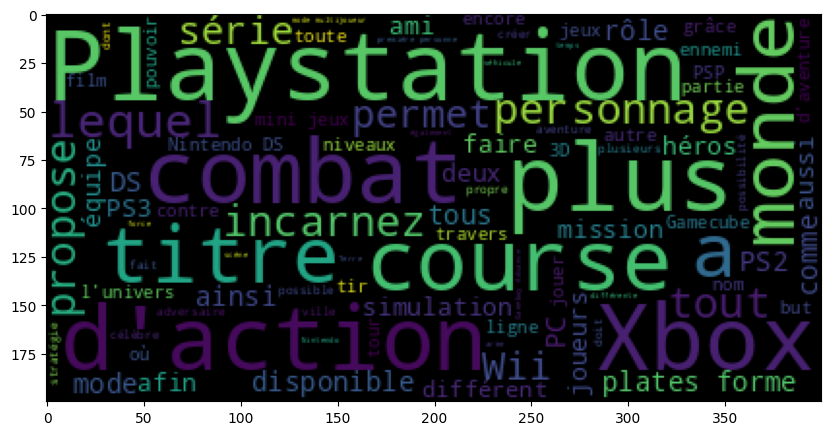

In [ ]:
# Affichage du nuage de mots pour Description_JVC
stop_words = set(stopwords.words('french'))
stop_words.update(["jeu","joueur"])

wc = WordCloud(background_color = 'black', max_words = 100, stopwords = stop_words, max_font_size = 50, random_state = 42)

# Générer et afficher le nuage de mots
plt.figure(figsize= (10,6)) # Initialisation d'une figure
wc.generate(Description_JVC)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

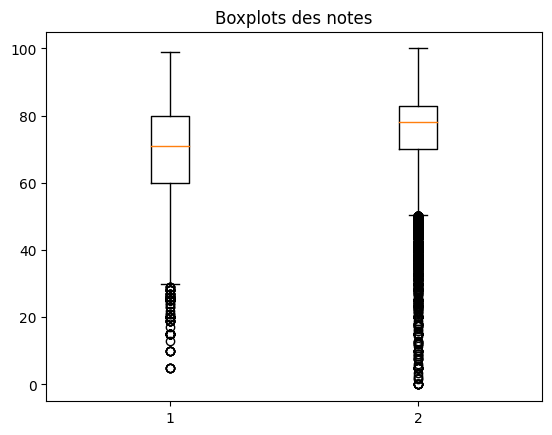

In [ ]:
# Distribution des notes pour choisir entre la médiane et la moyenne lors du remplacement des valeurs manquantes
df_notes = df.dropna(subset = ['NotePro','NoteJoueurs'])

plt.boxplot([df_notes.NotePro, df_notes.NoteJoueurs])
plt.title("Boxplots des notes");

In [16]:
# Aperçu du nombre de jeux Solo et Online sur le jeu de données
print("Nombre de jeux Solo ou non :")
print(df.Solo.value_counts())
print("\n")
print("Nombre de jeux Online ou non :")
print(df.Online.value_counts())

Nombre de jeux Solo ou non :
0    7988
1    4632
Name: Solo, dtype: Int64


Nombre de jeux Online ou non :
0    10128
1     2492
Name: Online, dtype: Int64


# **Etape 2 : Datavisualisation des données**

In [15]:
# Afficher le jeu le plus vendu (à l’échelle mondiale) par année et par plateforme
globalSalesByYear = df.copy()
globalSalesByYear = globalSalesByYear.sort_values('Global_Sales', ascending=False).drop_duplicates(['Year'])
globalSalesByYear = globalSalesByYear.sort_values('Year', ascending=True).drop(["NA_Sales","EU_Sales","JP_Sales","Other_Sales","Rank", "Rating", "Description_M", "Description_JVC", "Developpeur", "NotePro", "NoteJoueurs", "Online", "Solo"], axis=1)
globalSalesByYear = globalSalesByYear.reset_index(inplace=False, drop=True)
globalSalesByYear

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Asteroids,2600,1980,Shooter,Atari,4.31
1,Pitfall!,2600,1981,Platform,Activision,4.50
2,Pac-Man,2600,1982,Puzzle,Atari,7.81
3,Baseball,NES,1983,Sports,Nintendo,3.20
4,Duck Hunt,NES,1984,Shooter,Nintendo,28.31
5,Super Mario Bros.,NES,1985,Platform,Nintendo,40.24
6,The Legend of Zelda,NES,1986,Action,Nintendo,6.51
7,Zelda II: The Adventure of Link,NES,1987,Adventure,Nintendo,4.38
8,Super Mario Bros. 3,NES,1988,Platform,Nintendo,17.28
9,Tetris,GB,1989,Puzzle,Nintendo,30.26


In [16]:
# Afficher le jeu le plus vendu (à l’échelle mondiale) par plate-forme
globalSalesByPlat = df.copy()
globalSalesByPlat = globalSalesByPlat.sort_values('Global_Sales', ascending=False).drop_duplicates(['Platform'])
globalSalesByPlat = globalSalesByPlat.sort_values('Platform', ascending=False).drop(["NA_Sales","EU_Sales","JP_Sales","Other_Sales","Rank", "Rating", "Description_M", "Description_JVC", "Developpeur", "NotePro", "NoteJoueurs", "Online", "Solo"], axis=1)
globalSalesByPlat = globalSalesByPlat.reset_index(inplace=False, drop=True)
globalSalesByPlat

,Name,Platform,Year,Genre,Publisher,Global_Sales
0,Call of Duty: Black Ops 3,XOne,2015,Shooter,Activision,7.30
1,Halo 2,XB,2004,Shooter,Microsoft Game Studios,8.49
2,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,21.82
3,Mario Kart 8,WiiU,2014,Racing,Nintendo,6.96
4,Wii Sports,Wii,2006,Sports,Nintendo,82.74
5,Final Fantasy,WS,2000,Role-Playing,SquareSoft,0.51
6,Doukyuusei,TG16,1995,Adventure,NEC,0.14
7,Super Mario World,SNES,1990,Platform,Nintendo,20.61
8,Sonic CD,SCD,1993,Platform,Sega,1.50
9,Virtua Fighter 2,SAT,1995,Fighting,Sega,1.93


In [17]:
# Afficher la somme des ventes totales (à l'echelle mondiale) pour les 5 meilleurs éditeurs de jeux vidéo
top5Publisher = df.copy()
top5Publisher = top5Publisher.groupby(by="Publisher")["Global_Sales"].sum().reset_index()
top5Publisher = top5Publisher.sort_values('Global_Sales', ascending=False).reset_index(drop=True)
top5Publisher.head()

,Publisher,Global_Sales
0,Nintendo,1789.47
1,Electronic Arts,1111.88
2,Activision,728.16
3,Sony Computer Entertainment,611.12
4,Ubisoft,474.79


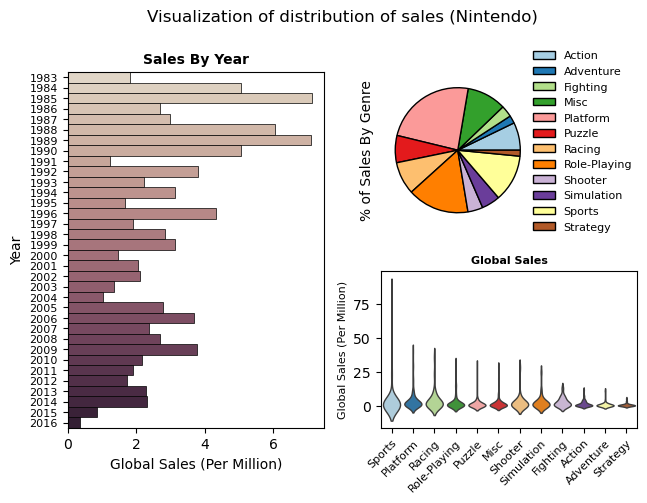

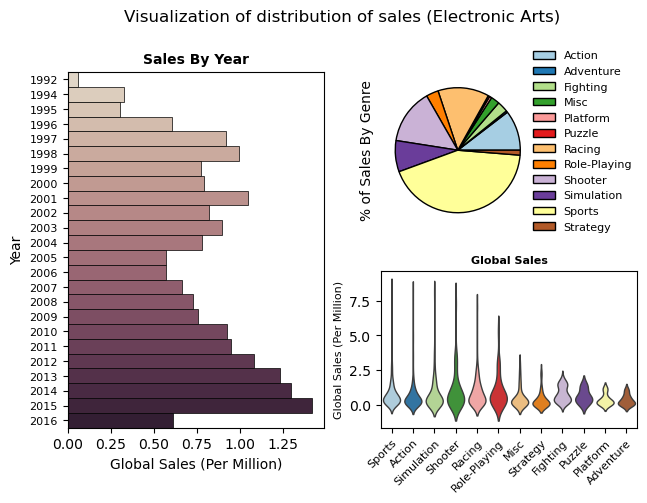

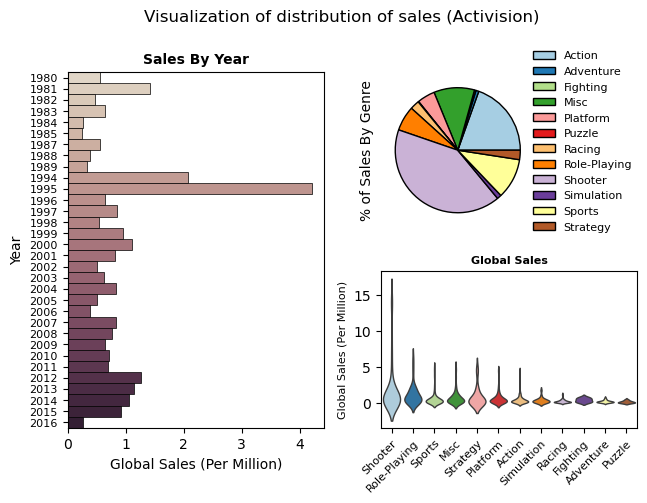

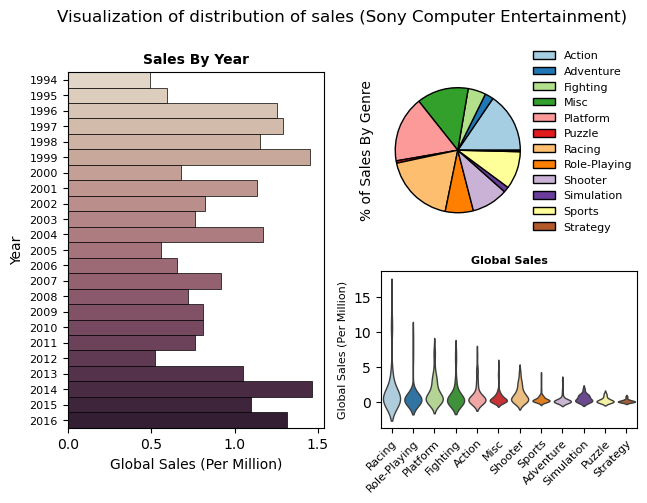

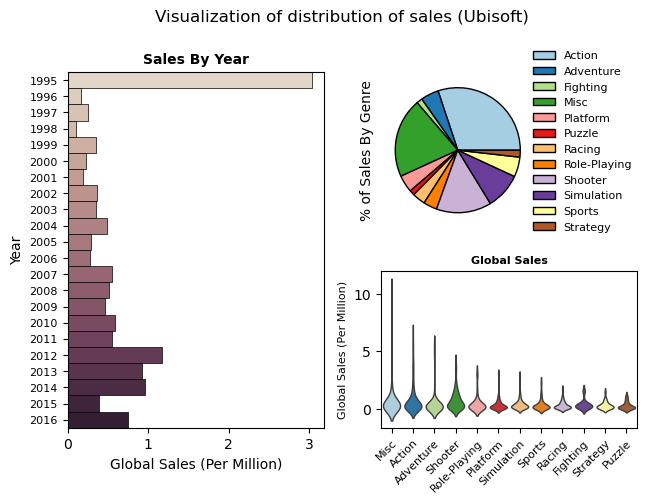

In [18]:
# Nous allons afficher pour chacun des 5 meilleurs éditeurs 'Nintendo', 'Electronic Arts', 'Activision', 'Sony Computer Entertainment' et 'Ubisoft'
# sur un graphique à barres horizontal (Barplot) son volume de ventes globales par année
# sur un camenbert (Pie plot) son pourcentage de ventes globales par le genre du jeu
# sur un viollon (violin plot) son volume de ventes globales par le genre du jeu

# Placing the names of the top 5 publishers into an array
top5 = ["Nintendo", "Electronic Arts", "Activision", "Sony Computer Entertainment", "Ubisoft"]
# Selecting a colour palette
pal = sns.color_palette("Paired", 12)
pal = pal.as_hex()[0:12]

# Initializing a for loop to generate each visualization set for each publisher in the top 5 array
for i in top5:
    # Querying for specifically one pulisher
    publisherData = df.query(f"Publisher == '{i}'")
    fig = plt.figure()

    # Initializing a subplot layout of 3 figures
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[:, 0])
    fig.suptitle(f'Visualization of distribution of sales ({i})')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95], pad=1)

    # Generating a Violin plot of Global sales by Genre
    try:
        sns.violinplot(x="Genre", y="Global_Sales", data=publisherData,ax=ax2, scale="width", inner=None, linewidth=1, edgecolor="black", palette=pal)
        ax2.tick_params(labelrotation=45, axis="x", labelsize=8)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        ax2.set_ylabel('Global Sales (Per Million)', fontsize=8)
        ax2.set_title('Global Sales', fontsize=8, fontweight="bold")
        ax2.set_xlabel('', fontsize=8)
    except:
        pass

    # Generating a Horizontal Bar plot of the Global sales by year
    try:
        publisherData["Year"] = publisherData["Year"].astype("category")
        sns.barplot(y="Year", x="Global_Sales", data=publisherData, ax=ax3, errorbar=None, palette="ch:.25", linewidth=0.5, edgecolor="black", width=1, orient="h")
        ax3.set_ylabel('Year', fontsize=10)
        ax3.set_xlabel('Global Sales (Per Million)')
        ax3.tick_params(axis="y", labelsize=8)
        ax3.set_title('Sales By Year', fontsize=10, fontweight="bold")
    except:
        pass

    # Generating a pie chart of global sales by genre
    try:
        genregroup = publisherData.groupby(['Genre'])["Global_Sales"].sum()
        genregroup.plot(kind='pie', y=["Global_Sales"], ax=ax1, legend=True,labeldistance=None, wedgeprops={'edgecolor':'black','linewidth': 1, 'linestyle': 'solid'}, colors=pal)
        ax1.legend(bbox_to_anchor=(1.68,1.2), loc="upper right", prop={"size":8}, frameon=False)
        box = ax1.get_position()
        box.x0 = box.x0 - 0.08
        box.x1 = box.x1 - 0.08
        ax1.set_position(box)
        ax1.set_ylabel('% of Sales By Genre', fontsize=10)
    except:
        pass

Ci-dessus, Nous avons créé 5 parcelles contenant chacune 3 sous-intrigues différentes pour chacun des 5 meilleurs éditeurs:
Chaque graphique contient un sous-graphique des éléments suivants :
(Gauche) Un graphique à barres horizontales des ventes mondiales par année pour ces éditeurs
(En haut à droite) Un graphique circulaire du % des ventes totales divisé par genre
(En bas à droite) Un tracé pour violon des ventes mondiales par genre
Ubisoft a une séparation intéressante avec les autres éditeurs de ce top 5 recevant la majorité de ses ventes en 1995.
Nintendo a de loin le succès le plus constant dans les ventes vendant constamment des numéros plus élevés d’année en année par rapport à l’autre top 5.
Tous les éditeurs ont une répartition similaire des ventes en comparant les parcelles de violon, à l’exception d’EA qui a moins de pic dans les ventes de sports, ce qui est contraire à mes hypothèses initiales car ils ont publié la franchise la plus vendue Fifa.

In [20]:
# Analyser le volume des sorties de jeux vidéo par année et par éditeurs pour les 5 meilleurs éditeurs 'Nintendo', 'Electronic Arts', 'Activision', 'Sony Computer Entertainment' et 'Ubisoft'
top5data = df.copy()
top5data = top5data[top5data["Publisher"].isin(top5)]
top5dataSlice = top5data.loc[:, ["Year", "Publisher", "Global_Sales"]]

<Axes: title={'center': 'Summary of volume of games by year by publisher'}, xlabel='Year', ylabel='Count of Games'>

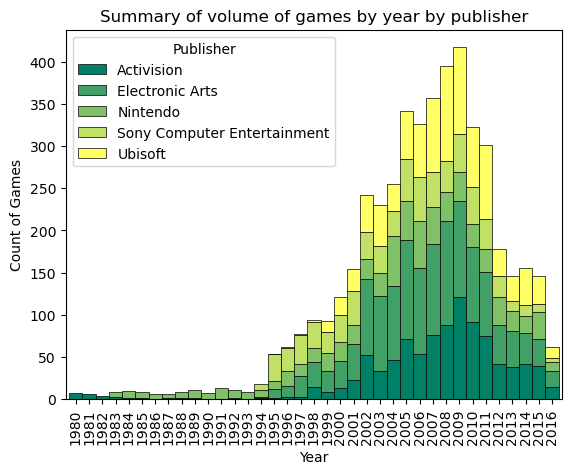

In [21]:
# puis tracer leur l'évolution au fil du temps dans un graphique à barres empilées
countData = top5dataSlice.groupby(["Publisher","Year"]).size().reset_index().pivot(columns="Publisher", index="Year", values=0)
countData.plot(kind="bar", stacked=True, linewidth=0.5, edgecolor="black", width=1, colormap="summer", ylabel="Count of Games", title="Summary of volume of games by year by publisher")

Le graphique ci-dessus est un graphique à barres empilées du nombre total de jeux produits chaque année divisé par les 5 principaux éditeurs:
Il est intéressant de noter qu’Activision, EA et Ubisoft semblent avoir produit un volume de jeux beaucoup plus élevé que Sony / Nintendo.
Montre que le succès de Nintendo en chiffres de vente est purement dû à des jeux plus vendus par rapport aux autres éditeurs du top 5.
La baisse des ventes en 2016 souligne également la probabilité que les ventes ne contiennent pas l’année complète.

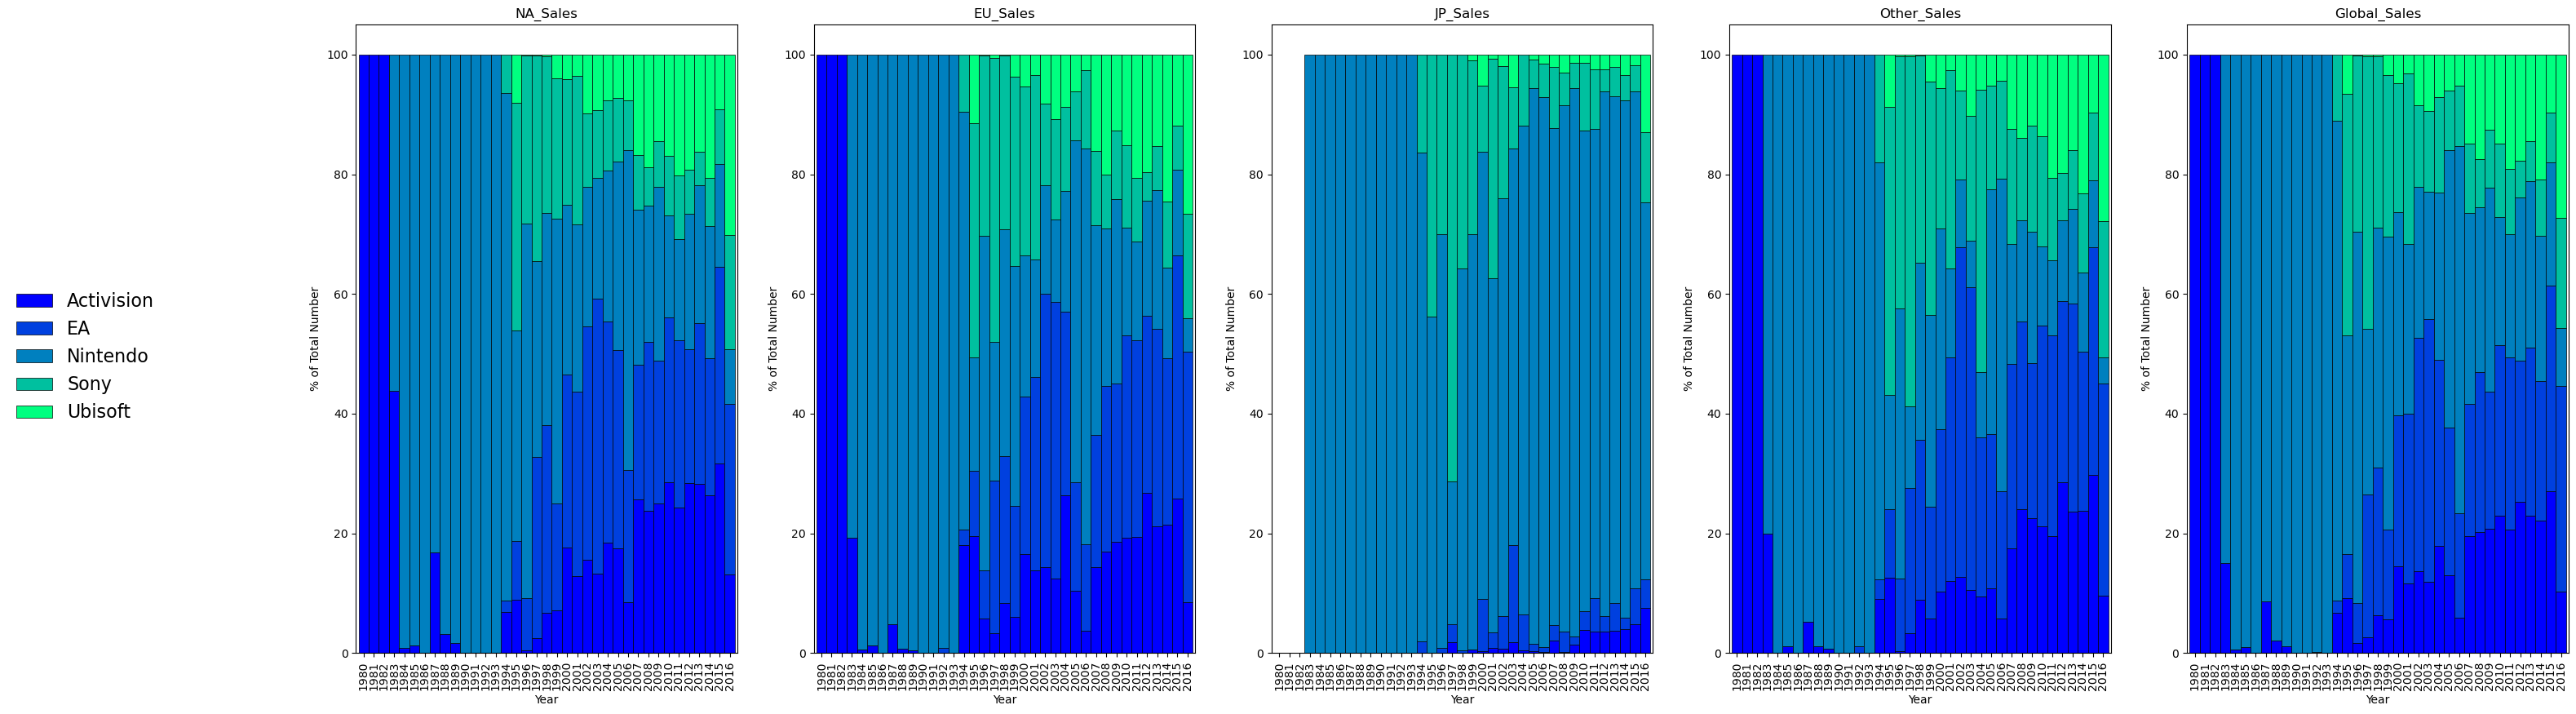

In [22]:
# Tracer le % du nombre total des ventes au fil du temps pour les 5 meilleurs éditeurs (Nintendo, Electronic Arts, Activision, Sony Computer Entertainment, Ubisoft) par région ()
fig, axes = plt.subplots(1, 5, figsize=(35,10))
z=0
sales = ["NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales"]
for i in sales:
    salesDataByRegion = top5data.loc[:, ["Year", "Publisher", i]]
    salesPivot = salesDataByRegion.groupby(["Publisher","Year"]).sum().reset_index().pivot(columns="Publisher", index="Year")
    salesPivot = salesPivot.fillna(0)
    columns = salesPivot.columns
    salesPivot["Total"] = salesPivot[columns[0]] + salesPivot[columns[1]] + salesPivot[columns[2]] + salesPivot[columns[3]] + salesPivot[columns[4]]
    for j in range(5):
        salesPivot[columns[j]] = salesPivot[columns[j]]/salesPivot["Total"]
    salesPivot=salesPivot.drop(columns="Total")

    ax= salesPivot.plot(kind="bar", stacked=True, linewidth=0.5, edgecolor="black", width=1, colormap="winter", ylabel=f"% of Total Number", title=i, ax=axes[z], legend=None)
    top5labels = ["Activision", "EA", "Nintendo", "Sony", "Ubisoft"]
    axes[z].set_yticklabels([0,20,40,60,80,100])
    z=z+1
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, top5labels, loc='center left', prop={"size":16}, frameon=False)

Les graphiques ci-dessus sont le % Nombre de ventes pour chaque année divisé par l’éditeur, chaque graphique représente une région différente identifiée par son titre:
NA / UE Ressemblent beaucoup au graphique Global_Sales indiquant leur impact sur l’ensemble du marché mondial.
D’autres ventes montrent une certaine ressemblance, mais diffèrent légèrement.
Les ventes de JP ne ressemblent de loin pas aux ventes mondiales mettant en évidence un groupe démographique plus unique par rapport aux autres régions.
Les ventes de JP sont entièrement dominées par Nintendo soulignant sa domination dans cette région.
Les ventes de Nintendo semblent diminuer comparativement à l’autre top 5, probablement en raison de l’établissement des autres éditeurs dans les années suivantes.
À partir des années 2000, Activision / EA s’impose comme le premier éditeur vendant plus de jeux que Nintendo.



The distribution of game sales by genre can be seen in the boxplots below:



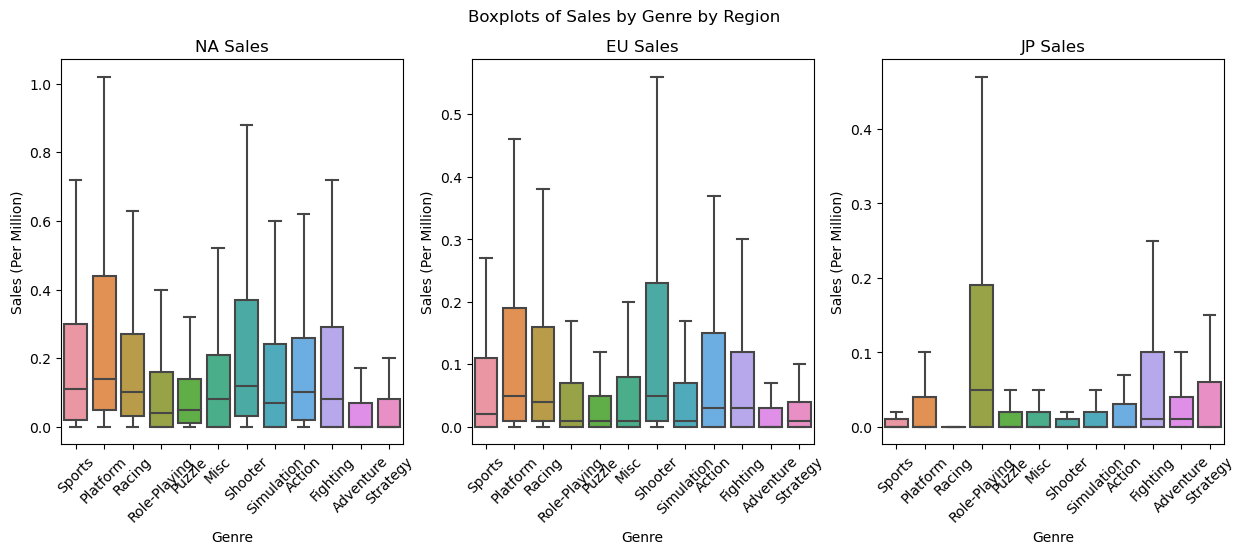

In [23]:
# Explorer la distribution des ventes de jeux vidéo par genre et par la region pour les trois plus gros marchés (NA Sales, EU Sales et JP Sales)
# Création de 3 boxplots des ventes par genre et par les régions (NA Sales, EU Sales et JP Sales)

# Creating a subplot:
print("\n\nThe distribution of game sales by genre can be seen in the boxplots below:")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Boxplots of Sales by Genre by Region')
# Plotting NA region sales in Subplot 1
sns.boxplot(x="Genre", y="NA_Sales", data=df, showfliers=False, ax=ax1)
ax1.tick_params(labelrotation=45, axis="x")
ax1.set_ylabel('Sales (Per Million)')
ax1.set_title('NA Sales')
# Plotting EU region sales in Subplot 2
ax2=sns.boxplot(x="Genre", y="EU_Sales", data=df, showfliers=False, ax=ax2)
ax2.tick_params(labelrotation=45, axis="x")
ax2.set_ylabel('Sales (Per Million)')
ax2.set_title('EU Sales')
# Plotting JP region sales in Subplot 3
ax3=sns.boxplot(x="Genre", y="JP_Sales", data=df, showfliers=False, ax=ax3)
ax3.tick_params(labelrotation=45, axis="x")
ax3.set_ylabel('Sales (Per Million)')
ax3.set_title('JP Sales')
print("")
# For these boxplots I have removed outliers as they heavily skew the axis.

Ci-dessus sont des sous-intrigues des ventes mondiales divisées par genre:
Higlights vu par l’échelle que NA a plus de ventes dans tous les genres
La répartition des ventes par genre suit une tendance relativement similaire dans les deux régions
Les faits saillants souhaités par les consommateurs sont assez similaires sur les deux marchés. Ceci est exploré plus loin dans l’intrigue suivante

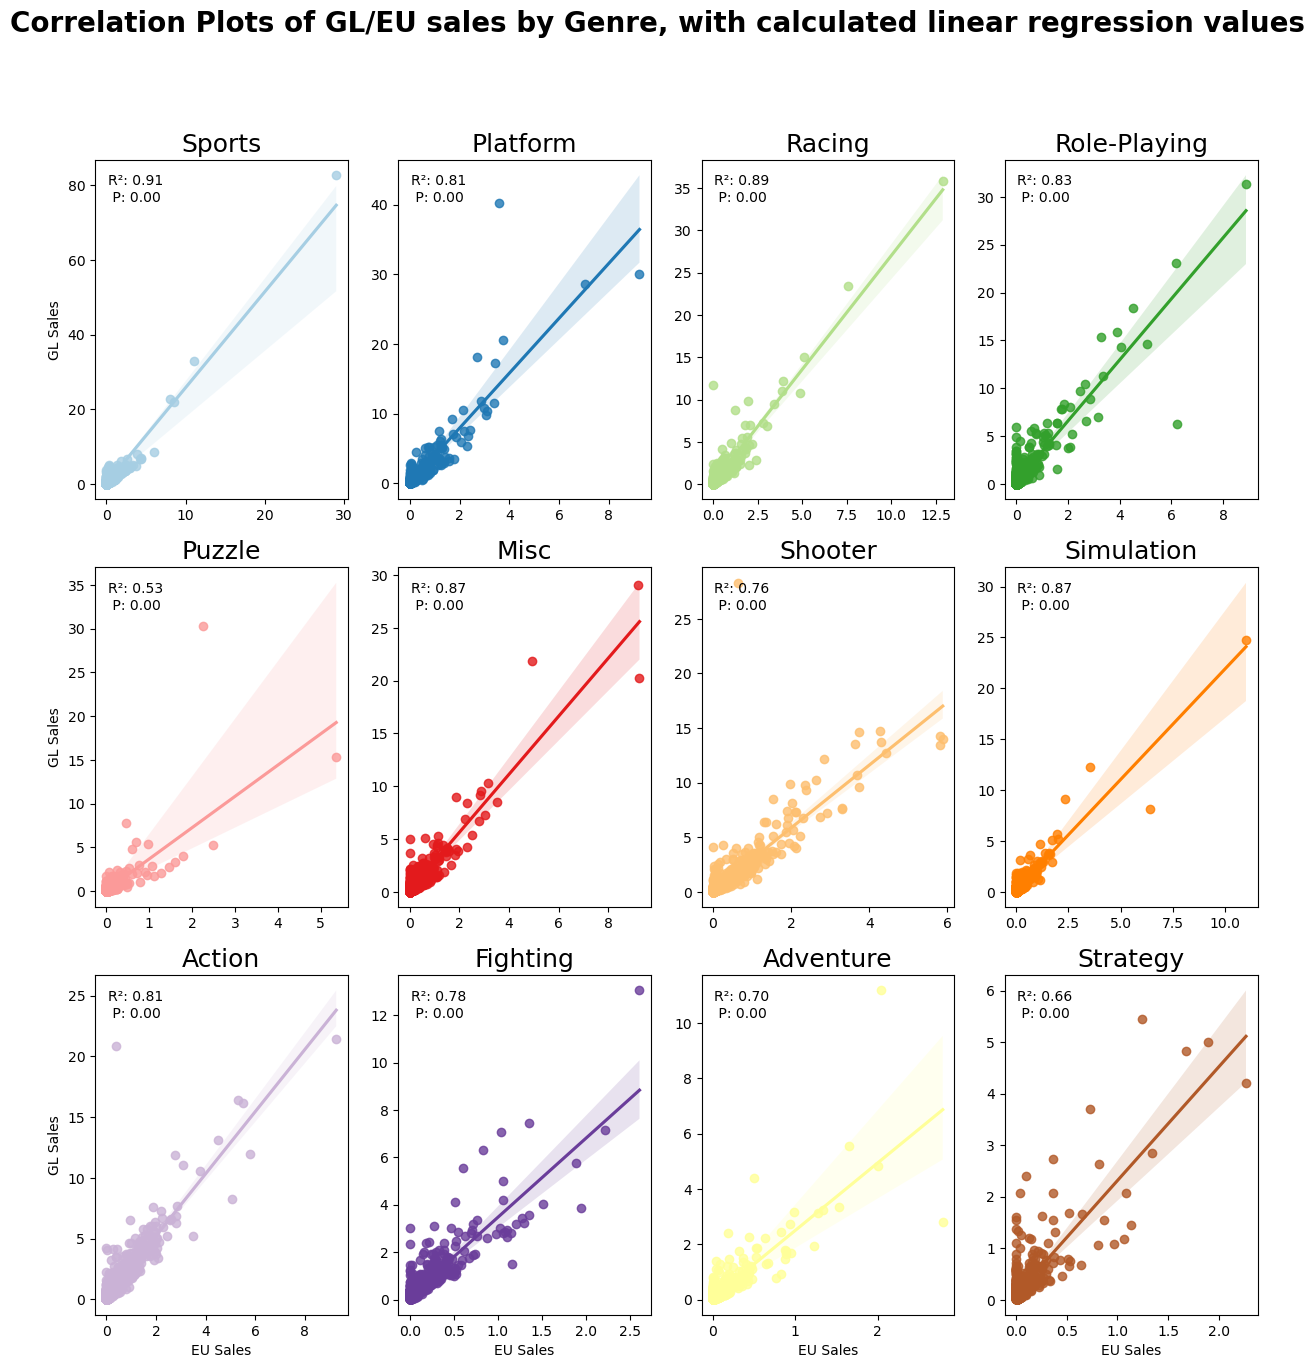

In [24]:
# tracer des diagrammes de régression linéaire et calculer les valeurs R2 et P pour la corrélation entre les variables 'Global_Sales' et 'EU_Sales'
fig, axes = plt.subplots(3, 4, figsize=(15,15))
fig.suptitle(f'Correlation Plots of GL/EU sales by Genre, with calculated linear regression values', fontsize=20, fontweight="bold", wrap=True)
x=0
y=0
z=0
# Finding and saving a list of all unique Genres
genres = df["Genre"].unique()
for i in genres:
    genreData = df.query(f"Genre == '{i}'")
    sns.regplot(data=genreData, ax=axes[y,x], x="EU_Sales", y="Global_Sales", color=pal[z])
    axes[y,x].set_title(i, fontsize=18)
    datax = genreData["Global_Sales"]
    datay = genreData["EU_Sales"]
    res = stats.linregress(datax, datay)
    axes[y,x].text(0.05,0.925, f"R\u00b2: {res.rvalue**2:.2f}", transform=axes[y,x].transAxes)
    axes[y,x].text(0.05,0.875, f" P: {res.pvalue**2:.2f}", transform=axes[y,x].transAxes)

    if x==0:
        axes[y,x].set_ylabel('GL Sales')
    else:
        axes[y,x].set_ylabel('')
    if y==2:
        axes[y,x].set_xlabel('EU Sales')
    else:
        axes[y,x].set_xlabel('')
    x=x+1
    z=z+1
    if x==4:
        x=0
        y=y+1

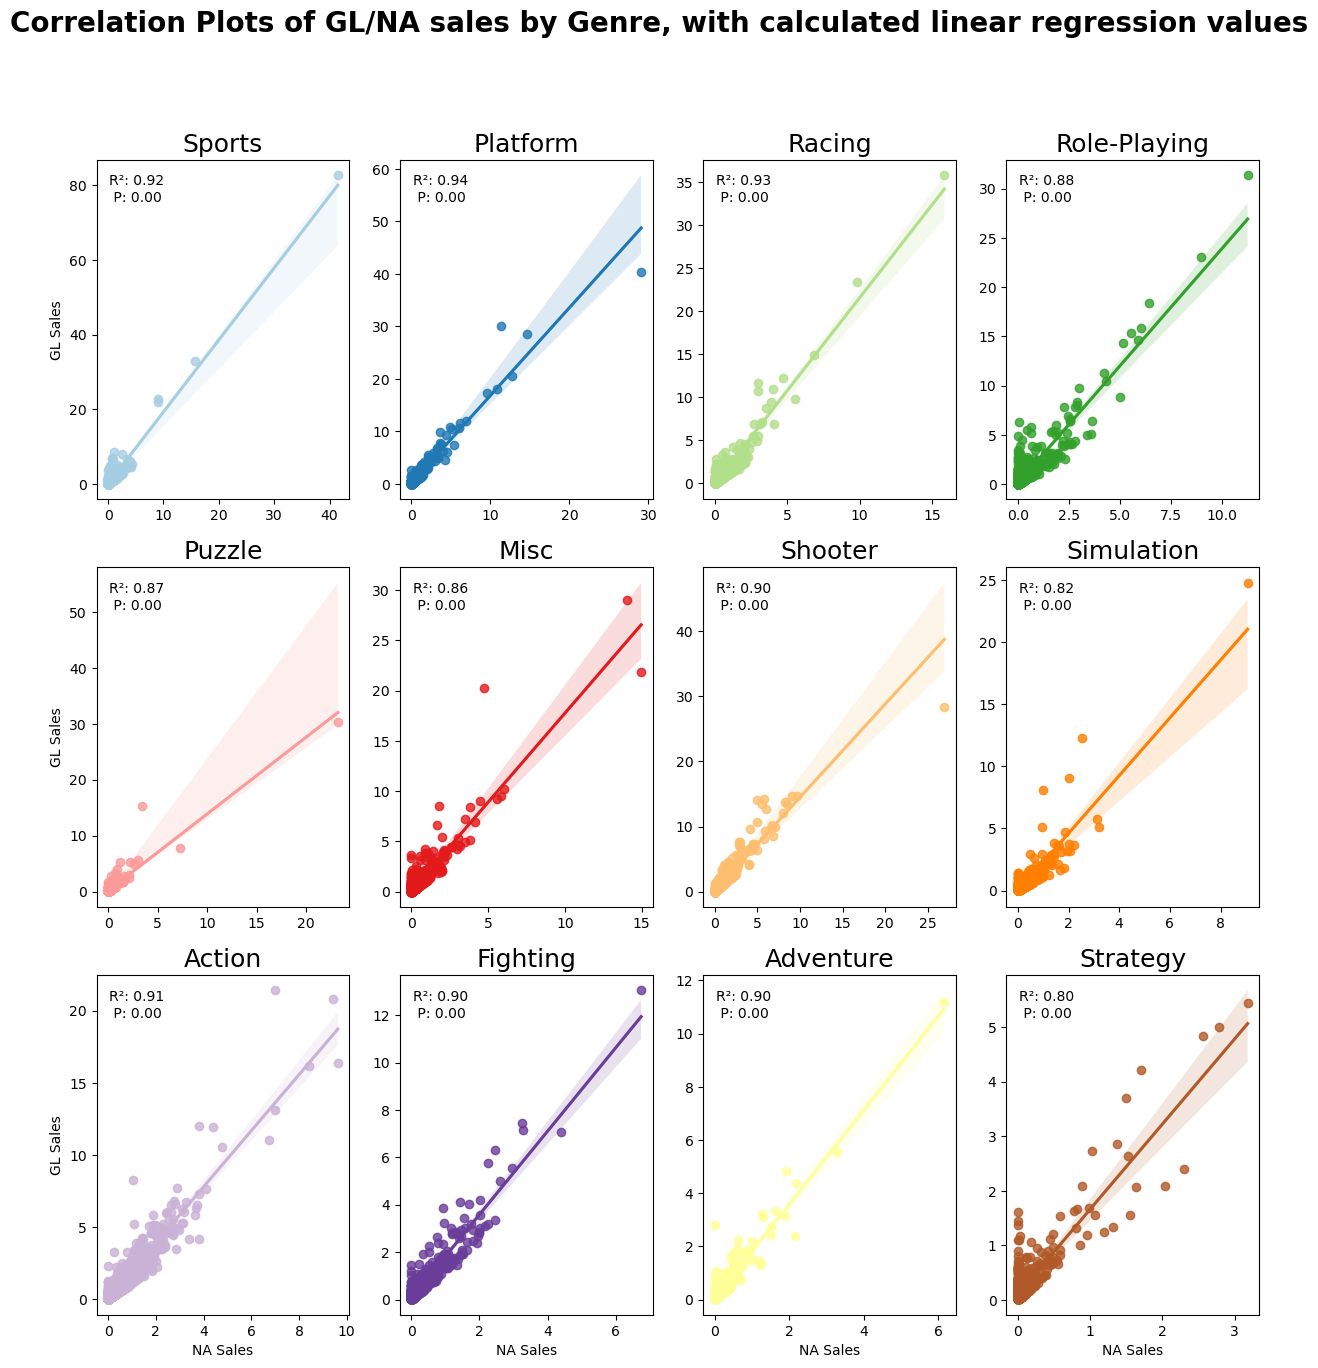

In [25]:
# tracer des diagrammes de régression linéaire et calculer les valeurs R2 et P pour la corrélation entre les variables 'Global_Sales' et 'NA_Sales'
fig, axes = plt.subplots(3, 4, figsize=(15,15))
fig.suptitle(f'Correlation Plots of GL/NA sales by Genre, with calculated linear regression values', fontsize=20, fontweight="bold", wrap=True)
x=0
y=0
z=0
# Finding and saving a list of all unique Genres
genres = df["Genre"].unique()
for i in genres:
    genreData = df.query(f"Genre == '{i}'")
    sns.regplot(data=genreData, ax=axes[y,x], x="NA_Sales", y="Global_Sales", color=pal[z])
    axes[y,x].set_title(i, fontsize=18)
    datax = genreData["Global_Sales"]
    datay = genreData["NA_Sales"]
    res = stats.linregress(datax, datay)
    axes[y,x].text(0.05,0.925, f"R\u00b2: {res.rvalue**2:.2f}", transform=axes[y,x].transAxes)
    axes[y,x].text(0.05,0.875, f" P: {res.pvalue**2:.2f}", transform=axes[y,x].transAxes)

    if x==0:
        axes[y,x].set_ylabel('GL Sales')
    else:
        axes[y,x].set_ylabel('')
    if y==2:
        axes[y,x].set_xlabel('NA Sales')
    else:
        axes[y,x].set_xlabel('')
    x=x+1
    z=z+1
    if x==4:
        x=0
        y=y+1

Ci-dessus sont representés des graphiques de régression, chaque graphique représente un genre différent. Un résultat statistique de régression linéaire est également imprimé pour chaque genre, affichant la valeur R^2 et la P value  en haut à gauche de chaque sous-tracé: Chaque régression qui y est affichée est en effet une corrélation pour chaque genre entre la variable cible (Global_Sales) et les varibles (NA_Sales et EU_Sales) qui representent respectivement le volume des ventes du marché nord américain et européen.
 La corrélation la plus forte était le sport, la course, le jeu de rôle parce que ce sont les genres de jeux les plus populaires, ces genres de jeux ont tendance à être produits par les plus grands éditeurs qui sont bien établis sur les deux marchés.

# **Etape 3 : Pré-processing des données**

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [27]:
# vérifier la présence de valeurs manquantes
df.isna().sum()

Rank                  0
Name                  0
Platform              0
Year                  0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Description_M      4620
Rating             4736
Description_JVC    4037
Developpeur        1817
NotePro            5434
NoteJoueurs        5001
Online             3941
Solo               3941
dtype: int64

In [28]:
# Afficher le nombre de valeurs uniques prises par chaque variable explicative.
print("Nombre de valeurs uniques par colonne:\n")
print(df.nunique())

Nombre de valeurs uniques par colonne:

Rank               16561
Name               11459
Platform              31
Year                  37
Genre                 12
Publisher            648
NA_Sales             409
EU_Sales             305
JP_Sales             244
Other_Sales          157
Global_Sales         623
Description_M       8652
Rating                 8
Description_JVC    11548
Developpeur         2089
NotePro               87
NoteJoueurs          183
Online                 2
Solo                   2
dtype: int64


In [29]:
# Quelles étapes de traitement allons nous devoir forcément appliquer à nos colonnes pour modéliser le problème à l'aide de la librairie scikit-learn? (Donnez au moins 2 étapes)
print("""
1) Certaines variables explicatives contiennent beaucoup de valeurs manquantes (NotePro et NoteJoueurs).
Nous allons devoir les remplir afin de ne pas perdre une grande partie du jeu de données.

2) Certaines colonnes sont sous format texte pour représenter une catégorie (Publisher).
Il va falloir les encoder numériquement.

3) Certaines colonnes non-numériques contiennent trop de modalités pour être encodées numériquement (Rank, Name, Developpeur, Description_M, Rating et Description_JVC").
On peut soit les supprimer soit extraire de ces valeurs des informations pertinentes pour la modélisation.
""")


1) Certaines variables explicatives contiennent beaucoup de valeurs manquantes (NotePro et NoteJoueurs).
Nous allons devoir les remplir afin de ne pas perdre une grande partie du jeu de données.

2) Certaines colonnes sont sous format texte pour représenter une catégorie (Publisher).
Il va falloir les encoder numériquement.

3) Certaines colonnes non-numériques contiennent trop de modalités pour être encodées numériquement (Rank, Name, Developpeur, Description_M, Rating et Description_JVC").
On peut soit les supprimer soit extraire de ces valeurs des informations pertinentes pour la modélisation.



In [30]:
# Afficher les modalités de la variable Publisher avec leurs fréquences respectives.
print("Nombre de modalités de la variable Publisher avec leurs fréquences respectives:\n")
print(df['Publisher'].value_counts())

Nombre de modalités de la variable Publisher avec leurs fréquences respectives:

Electronic Arts                 1355
Activision                       979
Namco Bandai Games               934
Ubisoft                          925
Konami Digital Entertainment     832
                                ... 
Evolution Games                    1
The Game Factory                   1
Aria                               1
Altron                             1
UIG Entertainment                  1
Name: Publisher, Length: 648, dtype: int64


In [31]:
# afficher dans une variable "top10Publisher" les dix modes les plus fréquents de la varaible "Publisher"
top10Publisher = df['Publisher'].value_counts().head(10)
top10Publisher

Electronic Arts                 1355
Activision                       979
Namco Bandai Games               934
Ubisoft                          925
Konami Digital Entertainment     832
THQ                              717
Nintendo                         716
Sony Computer Entertainment      689
Sega                             642
Take-Two Interactive             413
Name: Publisher, dtype: int64

In [32]:
# vérifier la présence de valeurs manquantes
df.isna().sum()

Rank                  0
Name                  0
Platform              0
Year                  0
Genre                 0
Publisher             0
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Description_M      4620
Rating             4736
Description_JVC    4037
Developpeur        1817
NotePro            5434
NoteJoueurs        5001
Online             3941
Solo               3941
dtype: int64

In [33]:
# Créer une fonction qui prend en argument une variable catégorielle et qui encode cette variable en une nouvelle variable "new_variable"
# Il ne reste plus qu'à renommer la variable "new_variable" comme vous le souhaitez
def encod(ma_variable):
    df['new_variable'] = [0 for i in range(len(df))]
    dix_premiers = df[ma_variable].value_counts().head(10)
    for i in range(len(df[ma_variable])):
        if df[ma_variable].iloc[i] in dix_premiers:
            for j in range(len(dix_premiers)) :
                if df[ma_variable].iloc[i] == dix_premiers.index[j]:
                    df['new_variable'].iloc[i] = j
        else:
            df['new_variable'].iloc[i] = 10

In [34]:
# Appel de la fonction encode() sur la variable 'Developpeur'
encod('Developpeur')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Description_M,Rating,Description_JVC,Developpeur,NotePro,NoteJoueurs,Online,Solo,new_variable
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Tennis (1-4 players): Players grab the control...,E,Wii Sports est une compilation de plusieurs pe...,Nintendo,76.0,81.0,0,0,5
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,Super Mario Bros. sur Nes est un jeu de plates...,Nintendo R&D4,95.0,93.0,0,0,10
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Mario Kart Wii comes with the intuitive Wii Wh...,E,Mario Kart Wii est le sixième volet de la fame...,Nintendo,82.0,85.0,1,0,5
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Wii Sports Resort is a collection of fun sport...,E,Wii Sports Resort sur Wii est une nouvelle ver...,Nintendo,80.0,83.0,0,0,5
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,Pokémon est un jeu de rôle sorti sur Gameboy. ...,Game Freak,80.0,91.0,0,0,10


In [35]:
# renommer la variable "new_variable" en "Top10Developer"
df = df.rename(columns={"new_variable": "Top10Developer"})
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Description_M,Rating,Description_JVC,Developpeur,NotePro,NoteJoueurs,Online,Solo,Top10Developer
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Tennis (1-4 players): Players grab the control...,E,Wii Sports est une compilation de plusieurs pe...,Nintendo,76.0,81.0,0,0,5
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,Super Mario Bros. sur Nes est un jeu de plates...,Nintendo R&D4,95.0,93.0,0,0,10
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Mario Kart Wii comes with the intuitive Wii Wh...,E,Mario Kart Wii est le sixième volet de la fame...,Nintendo,82.0,85.0,1,0,5
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Wii Sports Resort is a collection of fun sport...,E,Wii Sports Resort sur Wii est une nouvelle ver...,Nintendo,80.0,83.0,0,0,5
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,Pokémon est un jeu de rôle sorti sur Gameboy. ...,Game Freak,80.0,91.0,0,0,10


In [36]:
# Appel de la fonction encode() sur la variable 'Publisher'
encod('Publisher')
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,...,Description_M,Rating,Description_JVC,Developpeur,NotePro,NoteJoueurs,Online,Solo,Top10Developer,new_variable
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,...,Tennis (1-4 players): Players grab the control...,E,Wii Sports est une compilation de plusieurs pe...,Nintendo,76.0,81.0,0,0,5,6
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,...,NaN,NaN,Super Mario Bros. sur Nes est un jeu de plates...,Nintendo R&D4,95.0,93.0,0,0,10,6
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,...,Mario Kart Wii comes with the intuitive Wii Wh...,E,Mario Kart Wii est le sixième volet de la fame...,Nintendo,82.0,85.0,1,0,5,6
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,...,Wii Sports Resort is a collection of fun sport...,E,Wii Sports Resort sur Wii est une nouvelle ver...,Nintendo,80.0,83.0,0,0,5,6
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,...,NaN,NaN,Pokémon est un jeu de rôle sorti sur Gameboy. ...,Game Freak,80.0,91.0,0,0,10,6


In [37]:
# renommer la variable "new_variable" en "Top10Publisher"
df = df.rename(columns={"new_variable": "Top10Publisher"})
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,...,Description_M,Rating,Description_JVC,Developpeur,NotePro,NoteJoueurs,Online,Solo,Top10Developer,Top10Publisher
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,...,Tennis (1-4 players): Players grab the control...,E,Wii Sports est une compilation de plusieurs pe...,Nintendo,76.0,81.0,0,0,5,6
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,...,NaN,NaN,Super Mario Bros. sur Nes est un jeu de plates...,Nintendo R&D4,95.0,93.0,0,0,10,6
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,...,Mario Kart Wii comes with the intuitive Wii Wh...,E,Mario Kart Wii est le sixième volet de la fame...,Nintendo,82.0,85.0,1,0,5,6
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,...,Wii Sports Resort is a collection of fun sport...,E,Wii Sports Resort sur Wii est une nouvelle ver...,Nintendo,80.0,83.0,0,0,5,6
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,...,NaN,NaN,Pokémon est un jeu de rôle sorti sur Gameboy. ...,Game Freak,80.0,91.0,0,0,10,6


In [38]:
# Supprimez les colonnes "Rank", "Rating", "Description_M", "Description_JVC", "Online", "Solo" et "Name" du DataFrame df.
df.drop(["Rank", "Name", "Developpeur", "Publisher", "NA_Sales" , "EU_Sales", "JP_Sales", "Other_Sales", "Rating", "Description_M", "Description_JVC", "Online", "Solo"], axis=1, inplace=True)
df.head()

,Platform,Year,Genre,Global_Sales,NotePro,NoteJoueurs,Top10Developer,Top10Publisher
0,Wii,2006,Sports,82.74,76.0,81.0,5,6
1,NES,1985,Platform,40.24,95.0,93.0,10,6
2,Wii,2008,Racing,35.82,82.0,85.0,5,6
3,Wii,2009,Sports,33.00,80.0,83.0,5,6
4,GB,1996,Role-Playing,31.37,80.0,91.0,10,6


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 0 to 16597
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Platform        16561 non-null  object 
 1   Year            16561 non-null  Int64  
 2   Genre           16561 non-null  object 
 3   Global_Sales    16561 non-null  float64
 4   NotePro         11127 non-null  float64
 5   NoteJoueurs     11560 non-null  float64
 6   Top10Developer  16561 non-null  int64  
 7   Top10Publisher  16561 non-null  int64  
dtypes: Int64(1), float64(3), int64(2), object(2)
memory usage: 1.2+ MB


In [40]:
# créer une variable y contenant la variable target. Créer un dataframe X_cat contenant les variables explicatives catégorielles et un dataframe X_num contenant les variables explicatives numériques.
y = df['Global_Sales']
X_cat = df[['Platform', 'Genre']]
X_num = df[['Year', 'NotePro', 'NoteJoueurs', 'Top10Developer', 'Top10Publisher']]

In [41]:
# remplacer les valeurs manquantes des variables catégorielles par le mode et remplacer les valeurs manquantes des variables numériques par la moyenne.
# encoder les variables catégorielles.
# concatener les variables explicatives encodées et sans valeurs manquantes pour obtenir un dataframe X clean
for col in X_cat.columns:
  X_cat[col] = X_cat[col].fillna(X_cat[col].mode()[0])
for col in X_num.columns:
  X_num[col] = X_num[col].fillna(X_num[col].mean())
X_cat_scaled = pd.get_dummies(X_cat, columns=X_cat.columns)
X = pd.concat([X_cat_scaled, X_num], axis = 1)

In [42]:
# géneration du fichier .csv
X.to_csv("preprocessed.csv", index=False)

In [43]:
# géneration du fichier .csv
y.to_csv("Global_Sales_preprocessed.csv", index=False)

In [44]:
pd.read_csv("preprocessed.csv")

,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,Platform_DS,Platform_GB,Platform_GBA,Platform_GC,Platform_GEN,Platform_GG,...,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Year,NotePro,NoteJoueurs,Top10Developer,Top10Publisher
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2006,76.0000,81.00000,5,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1985,95.0000,93.00000,10,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2008,82.0000,85.00000,5,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2009,80.0000,83.00000,5,6
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1996,80.0000,91.00000,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16556,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2002,67.9441,25.00000,10,10
16557,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,2003,67.9441,51.50000,10,10
16558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2008,25.0000,20.00000,10,1
16559,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2010,67.9441,73.94987,10,10


In [45]:
df_prep = pd.read_csv("preprocessed.csv")
df_prep.shape

(16561, 48)

In [46]:
# séparer les données en un ensemble d'entrainement et un ensemble test en utilisant la fonction train_test_split du package model_selection de Scikit-Learn.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [47]:
# standardiser les valeurs numériques en utilisant la fonction StandardScaler du package Preprocessing de Scikit-Learn.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[X_num.columns] = scaler.fit_transform(X_train[X_num.columns])
X_test[X_num.columns] = scaler.transform(X_test[X_num.columns])

# **Etape 4 : Modélisation des Données**

**1. Régression linéaire**

In [48]:
# Instancier un modèle LinearRegression de régression linéaire et entrainez le sur vos données d'entrainement.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [49]:
# Afficher l'intercept ainsi que les coefficients de chaque valeur estimée par le modèle.
coeffs = list(reg.coef_)
coeffs.insert(0, reg.intercept_)

feats2 = list(X.columns)
feats2.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats2)

,valeur estimée
intercept,1.770778e+12
Platform_2600,-1.770778e+12
Platform_3DO,-1.770778e+12
Platform_3DS,-1.770778e+12
Platform_DC,-1.770778e+12
Platform_DS,-1.770778e+12
Platform_GB,-1.770778e+12
Platform_GBA,-1.770778e+12
Platform_GC,-1.770778e+12
Platform_GEN,-1.770778e+12


In [50]:
# Afficher le score (R²) du modèle sur le jeu de données de d'entraînement et de test.
print('Coefficient de détermination du modèle sur train:', reg.score(X_train, y_train))
print('Coefficient de détermination du modèle sur test:', reg.score(X_test, y_test))

Coefficient de détermination du modèle sur train: 0.10414996895781725
Coefficient de détermination du modèle sur test: 0.10903528992658063


Plus le coefficient de détermination est proche de 1, plus les données collent à la droite de régression.

In [51]:
import joblib
joblib.dump(reg, "model_reg_line")

['model_reg_line']

In [52]:
# (1) Stocker les prédictions du modèle pour X_test dans une variable nommé y_pred_reg.
y_pred_reg = reg.predict(X_test)
print("Score :", r2_score(y_test, y_pred_reg))

Score : 0.10903528992658063


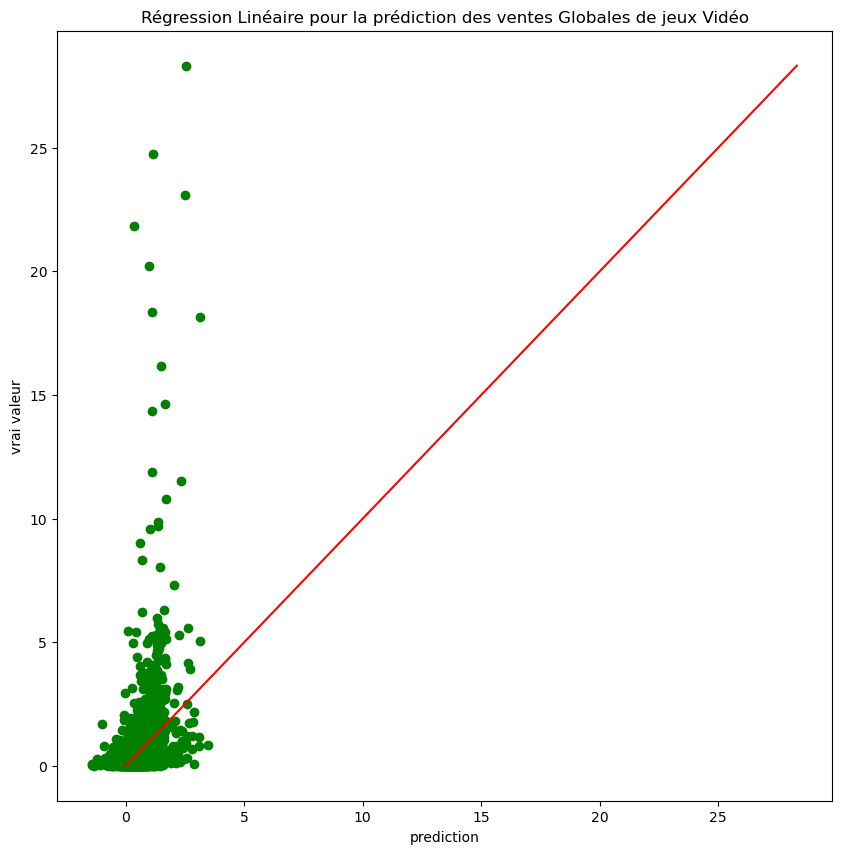

In [53]:
# (2) Afficher dans un graphique le nuage de points entre y_pred_reg et y_test.
# (3) Ajouter sur ce graphique la droite d'équation  𝑦=𝑥
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,10))
plt.scatter(y_pred_reg, y_test, c='green')
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.xlabel("prediction")
plt.ylabel("vrai valeur")
plt.title('Régression Linéaire pour la prédiction des ventes Globales de jeux Vidéo')

plt.show();

**2. DecisionTreeRegressor**

In [54]:
# (1) Instancier un objet DecisionTreeRegressor de la bibliothèque sklearn.tree et entraînez le sur vos données d'entraînement.
# (2) Évaluer le modèle à l'aide de la méthode score sur les données d'entraînement et de test.
from sklearn.tree import DecisionTreeRegressor

reg_dt = DecisionTreeRegressor(random_state=123)
reg_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

In [55]:
#On observe un réel overfitting
print(reg_dt.score(X_train,y_train))
print(reg_dt.score(X_test,y_test))

0.9963486235021709
-0.9555059189516377


In [56]:
# sauvegarde du modèle entrainé
joblib.dump(reg_dt, "model_reg_dt")

['model_reg_dt']

In [57]:
# (1) Stocker les prédictions du modèle pour X_test dans une variable nommé y_pred_dt.
y_pred_dt = reg_dt.predict(X_test)
print("Score :", r2_score(y_test, y_pred_dt))

Score : -0.9555059189516377


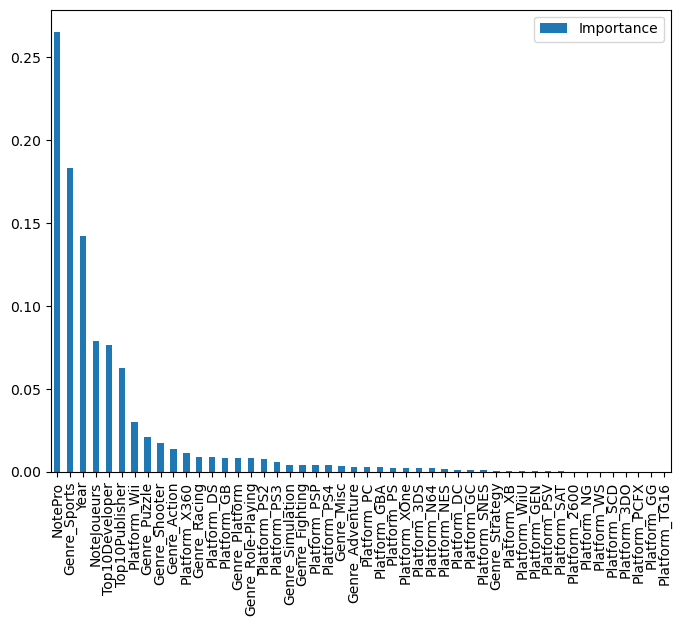

In [58]:
# Ici, nous pouvons calculer l'importance de chacune des variables grâce à l'attribut "feature_importances_" de notre arbre de décision.
import matplotlib.pyplot as plt

feat_importances = pd.DataFrame(reg_dt.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
plt.show();

In [59]:
# Réentrainer votre modèle en ne gardant que les six variables les plus importantes, comparez ces résultats avec le modèle précédent. Que pouvez-vous conclure ?
from sklearn.tree import DecisionTreeRegressor


X_train_reduced = X_train[['NotePro','Genre_Sports','Year', 'NoteJoueurs', 'Top10Developer', 'Top10Publisher']].copy()
X_test_reduced = X_test[['NotePro','Genre_Sports','Year', 'NoteJoueurs', 'Top10Developer', 'Top10Publisher']].copy()

reg_dt = DecisionTreeRegressor(random_state=123)
reg_dt.fit(X_train_reduced , y_train)

print(reg_dt.score(X_train_reduced,y_train))
print(reg_dt.score(X_test_reduced,y_test))

0.9829324144026946
-0.30364592832961845


**3. Random Forest Regressor**

In [60]:
# (1) Instancier un objet RandomForestRegressor de la bibliothèque sklearn.ensemble et entrainez le jeu de données d'entraînement.
# (2) Afficher les scores d'entraînement et de test du modèle
from sklearn.ensemble import RandomForestRegressor

reg_rf = RandomForestRegressor(random_state=123)
reg_rf.fit(X_train, y_train)

print(reg_rf.score(X_train,y_train))
print(reg_rf.score(X_test,y_test))

0.8994970193595265
0.26627649226490924


In [61]:
# sauvegarde du modèle entrainé
joblib.dump(reg_rf, "model_reg_rf")

['model_reg_rf']

In [62]:
# (1) Stocker les prédictions du modèle pour X_test dans une variable nommé y_pred_rf.
y_pred_rf = reg_rf.predict(X_test)
print("Score :", r2_score(y_test, y_pred_rf))

Score : 0.26627649226490924


In [63]:
# (1) Calculer ces trois métriques sur le jeu d'entraînement et le jeu de test pour le DecisionTreeRegressor,
# (2) Calculer ces trois métriques sur le jeu d'entraînement et le jeu de test pour le RandomForestRegressor,
# (3) Stocker l'ensemble de ces mesures dans un DataFrame et l'afficher.
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### DecisionTree

regressor_decision_tree = DecisionTreeRegressor(random_state=123)
regressor_decision_tree.fit(X_train, y_train)


y_pred_decision_tree = regressor_decision_tree.predict(X_test)
y_pred_train_decision_tree = regressor_decision_tree.predict(X_train)

# Calcul des métriques

# jeu d'entraînement
mae_decision_tree_train = mean_absolute_error(y_train,y_pred_train_decision_tree)
mse_decision_tree_train = mean_squared_error(y_train,y_pred_train_decision_tree,squared=True)
rmse_decision_tree_train = mean_squared_error(y_train,y_pred_train_decision_tree,squared=False)

# jeu de test
mae_decision_tree_test = mean_absolute_error(y_test,y_pred_decision_tree)
mse_decision_tree_test = mean_squared_error(y_test,y_pred_decision_tree,squared=True)
rmse_decision_tree_test = mean_squared_error(y_test,y_pred_decision_tree,squared=False)


### RandomForest

regressor_random_forest = RandomForestRegressor(random_state=123)
regressor_random_forest.fit(X_train, y_train)

# Calcul des métriques
y_pred_random_forest = regressor_random_forest.predict(X_test)
y_pred_random_forest_train = regressor_random_forest.predict(X_train)


# jeu d'entraînement
mae_random_forest_train = mean_absolute_error(y_train,y_pred_random_forest_train)
mse_random_forest_train = mean_squared_error(y_train,y_pred_random_forest_train,squared=True)
rmse_random_forest_train = mean_squared_error(y_train,y_pred_random_forest_train,squared=False)

# jeu de test
mae_random_forest_test = mean_absolute_error(y_test,y_pred_random_forest)
mse_random_forest_test = mean_squared_error(y_test,y_pred_random_forest,squared=True)
rmse_random_forest_test = mean_squared_error(y_test,y_pred_random_forest,squared=False)


# Creation d'un dataframe pour comparer les metriques des deux algorithmes
data = {'MAE train': [mae_decision_tree_train, mae_random_forest_train],
        'MAE test': [mae_decision_tree_test, mae_random_forest_test],
        'MSE train': [mse_decision_tree_train,mse_random_forest_train],
        'MSE test': [mse_decision_tree_test,mse_random_forest_test],
        'RMSE train': [rmse_decision_tree_train, rmse_random_forest_train],
        'RMSE test': [rmse_decision_tree_test, rmse_random_forest_test]}

# Creer DataFrame
df = pd.DataFrame(data, index = ['Decision Tree', 'Random Forest '])

df.head()

,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test
Decision Tree,0.018394,0.560407,0.009198,3.987804,0.095905,1.996949
Random Forest,0.171669,0.450194,0.253166,1.496260,0.503156,1.223217


**Conclusion**

On observe que les résultats les plus élevés sur les données d'entraînement et de test sont fournis avec le modèle Random Forest. Pour aller plus loin, nous pourrions essayer d'optimiser les paramètres de chacun des modèles afin d'avoir le meilleur score possible tout en tentant de réduire l'overfitting.

A retenir

Il existe plusieurs manières de résoudre un problème de régression, nous donnant à chaque fois de nouvelles manières d'interpréter et des résultats différents.
Les coefficients donnés par la régression linéaire simple permettent de donner l'impact de la modification des variables sur les ventes de jeux vidéo. De manière parallèle, nous pouvons retrouver de l'information sur les différentes variables et leur importance grâce à l'importance calculée sur les méthodes arbres et les méthodes ensemblistes.
Le score  𝑅2
  n'est pas la métrique à privilégier si on applique un modèle non-linéaire : on préfèrera la MSE, la MAE et le RMSE.
Le résultat des métriques est à mettre en relation avec l'ordre de grandeur de la variable cible que l'on cherche à prédire.

 **Bonus**

la pipeline Scikit-Learn

Comme lors de la partie classification, vous avez vu dans le notebook 4 les pipelines Scikit-Learn : elles permettent de condenser le code et de centraliser toutes les opérations de transformation.

Exécuter la cellule suivante pour entraîner la pipeline et afficher le résultat.

In [ ]:
numeric_variables = df[["Year", "NotePro", "NoteJoueurs", "Top10Developer", "Top10Publisher"]]
categorical_variables = df[["Platform", "Genre"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

# Column Tranformer pour appliquer les transformations sur certaines colonnes
preprocessor = ColumnTransformer(
    transformers = [
        # Standardisation sur les variables numériques
        ("Scaling numeric variables", StandardScaler() , numeric_variables),
        # Encodage des données sur les variables catégorielles
        ("Encoding categorical variables", pd.get_dummies(categorical_variables, columns=categorical_variables.columns))
    ])


# Pipeline de regroupement
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("regression", DecisionTreeRegressor())]
    )


clf.fit(X_train, y_train)

y_pred_decision_tree = clf.predict(X_test)

mae_decision_tree_train = mean_absolute_error(y_test,y_pred_decision_tree)

print("model mae: %.3f" % mae_decision_tree_train)


Le **ColumnTranformer** preprocessor permet de spécifier que les opérations vont s'effectuer uniquement sur certaines colonnes:

Un StandardScaler sur les variables "Year", "NotePro", "NoteJoueurs", "Top10Developer", "Top10Publisher",

Un OneHotEncoder sur les variables "Platform", "Genre",

La Pipeline **clf** permet de rassembler ses transformations et d'entraîner un modèle de régression, ici le DecisionTreeRegressor.